In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Villanova62_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Villanova62_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [ ]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Villanova62', ref_nodes) 
            np.save('results/info_ref_nodes_Villanova62', info_ref_nodes) 
        
    number_feature += 1

## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [ ]:
ref_nodes = np.load('results/ref_nodes_Villanova62.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Villanova62.npy') 

## Visualize the ground truth clusters

In [ ]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [53]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Villanova62', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Villanova62', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Villanova62', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Villanova62', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Villanova62', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Villanova62', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Villanova62', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Villanova62', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Villanova62', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Villanova62', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Villanova62', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Villanova62', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Villanova62', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Villanova62', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Villanova62', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Villanova62', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Villanova62', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Villanova62', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Villanova62', cuts_acl_ALL) 
    
    np.save('results/nodes_Villanova62', nodes)

100
outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.1936214708957825 f1score:  0.9269348728125565 precision:  0.8954339491111886 recall:  0.9607329842931938
outer: 0 number of node:  928  completed:  0.01  degree:  45.0
conductance:  0.21091254424587758 f1score:  0.9117105794694557 precision:  0.8768022101355435 recall:  0.949513836948392
outer: 0 number of node:  2365  completed:  0.02  degree:  74.0
conductance:  0.1895143190591615 f1score:  0.9292420425921686 precision:  0.9107639824041656 recall:  0.9484854151084517
outer: 0 number of node:  2776  completed:  0.03  degree:  36.0
conductance:  0.1966483372610631 f1score:  0.914909944477046 precision:  0.8845247446975648 recall:  0.9474569932685116
outer: 0 number of node:  3898  completed:  0.04  degree:  32.0
conductance:  0.18148820326678766 f1score:  0.9361760913612083 precision:  0.9224137931034483 recall:  0.950355272999252
outer: 0 number of node:  4909  completed:  0.05  degree:  54.0
conductan

outer: 0 number of node:  1718  completed:  0.45  degree:  39.0
conductance:  0.20185449358059915 f1score:  0.9288061336254108 precision:  0.9072753209700428 recall:  0.9513836948391923
outer: 0 number of node:  4746  completed:  0.46  degree:  18.0
conductance:  0.17730462481737838 f1score:  0.3960037369635265 precision:  0.24872464254065577 recall:  0.9709237097980553
outer: 0 number of node:  2530  completed:  0.47  degree:  41.0
conductance:  0.1826282712691117 f1score:  0.9338846730585724 precision:  0.9084961541861905 recall:  0.9607329842931938
outer: 0 number of node:  686  completed:  0.48  degree:  54.0
conductance:  0.2177800269905533 f1score:  0.9140652713728271 precision:  0.8693488529014844 recall:  0.9636312640239342
outer: 0 number of node:  2765  completed:  0.49  degree:  153.0
conductance:  0.2728902245954866 f1score:  0.10857174759301835 precision:  0.057401991037647246 recall:  1.0
outer: 0 number of node:  3594  completed:  0.5  degree:  47.0
conductance:  0.20055

outer: 0 number of node:  522  completed:  0.9  degree:  99.0
conductance:  0.20158484731349052 f1score:  0.8930811632769435 precision:  0.9080981832238114 recall:  0.8785527299925205
outer: 0 number of node:  3539  completed:  0.91  degree:  12.0
conductance:  0.18921449302499765 f1score:  0.9118211161528745 precision:  0.9124613800205973 recall:  0.9111817501869858
outer: 0 number of node:  1126  completed:  0.92  degree:  73.0
conductance:  0.18265800786609349 f1score:  0.9353183226224052 precision:  0.9251806457513949 recall:  0.9456806282722513
outer: 0 number of node:  4380  completed:  0.93  degree:  47.0
conductance:  0.19941051855945474 f1score:  0.9076230687143322 precision:  0.9008934328083265 recall:  0.9144540014958863
outer: 0 number of node:  2581  completed:  0.94  degree:  55.0
conductance:  0.21297429620563035 f1score:  0.9082858950031626 precision:  0.8788249694002448 recall:  0.9397905759162304
outer: 0 number of node:  4818  completed:  0.95  degree:  47.0
conducta

outer: 1 number of node:  1549  completed:  0.07017543859649122  degree:  46.0
conductance:  0.3066280410933183 f1score:  0.5089497920380273 precision:  0.36761352967999783 recall:  0.8268476621417797
outer: 1 number of node:  881  completed:  0.07236842105263158  degree:  220.0
conductance:  0.2494539756475822 f1score:  0.5591678924143728 precision:  0.42899887151378363 recall:  0.8027390648567119
outer: 1 number of node:  4747  completed:  0.07456140350877193  degree:  78.0
conductance:  0.3209470868556052 f1score:  0.6344255823134622 precision:  0.49228494748969437 recall:  0.8919698340874811
outer: 1 number of node:  1069  completed:  0.07675438596491228  degree:  142.0
conductance:  0.25293294066528266 f1score:  0.5532536301907068 precision:  0.4316353162314568 recall:  0.7702926093514328
outer: 1 number of node:  961  completed:  0.07894736842105263  degree:  27.0
conductance:  0.3317536053181794 f1score:  0.5250603920753723 precision:  0.3791194658492932 recall:  0.8536832579185

outer: 1 number of node:  1998  completed:  0.1600877192982456  degree:  32.0
conductance:  0.3404387639124188 f1score:  0.6328936822745109 precision:  0.513663914331694 recall:  0.8242051282051283
outer: 1 number of node:  1904  completed:  0.16228070175438597  degree:  103.0
conductance:  0.29094067315012384 f1score:  0.6130828304991771 precision:  0.49349817860691025 recall:  0.809158371040724
outer: 1 number of node:  4249  completed:  0.16447368421052633  degree:  39.0
conductance:  0.30817151496306144 f1score:  0.5967983789260385 precision:  0.5143331150403841 recall:  0.7107571644042232
outer: 1 number of node:  4306  completed:  0.16666666666666666  degree:  8.0
conductance:  0.30829848825989065 f1score:  0.6382579013285528 precision:  0.6496894099413816 recall:  0.6272217194570135
outer: 1 number of node:  401  completed:  0.16885964912280702  degree:  215.0
conductance:  0.2657111952406706 f1score:  0.5299352750809061 precision:  0.3826652302315984 recall:  0.8614781297134239

outer: 1 number of node:  429  completed:  0.25  degree:  19.0
conductance:  0.28339981128838565 f1score:  0.5703995244067016 precision:  0.44536300432325476 recall:  0.7930497737556561
outer: 1 number of node:  1342  completed:  0.25219298245614036  degree:  152.0
conductance:  0.24206802283508885 f1score:  0.496209373186303 precision:  0.39746057572874066 recall:  0.6602473604826546
outer: 1 number of node:  3608  completed:  0.2543859649122807  degree:  189.0
conductance:  0.2649927571221632 f1score:  0.6281049775011054 precision:  0.4901456668673843 recall:  0.8741478129713424
outer: 1 number of node:  3784  completed:  0.2565789473684211  degree:  73.0
conductance:  0.2571566420070762 f1score:  0.5301992572660316 precision:  0.43897999240217805 recall:  0.6692730015082956
outer: 1 number of node:  790  completed:  0.25877192982456143  degree:  141.0
conductance:  0.263107834978005 f1score:  0.6623425584004433 precision:  0.5310883848316653 recall:  0.8797707390648567
outer: 1 numb

outer: 1 number of node:  50  completed:  0.3399122807017544  degree:  58.0
conductance:  0.2891378339988744 f1score:  0.5884789490813338 precision:  0.49758587046256225 recall:  0.72
outer: 1 number of node:  3310  completed:  0.34210526315789475  degree:  23.0
conductance:  0.28314470601480785 f1score:  0.5141214185682816 precision:  0.37139744319096635 recall:  0.8350045248868778
outer: 1 number of node:  644  completed:  0.3442982456140351  degree:  82.0
conductance:  0.32398850747228713 f1score:  0.49927448295313265 precision:  0.3605162175488241 recall:  0.8116802413273001
outer: 1 number of node:  3156  completed:  0.34649122807017546  degree:  54.0
conductance:  0.32681718504538604 f1score:  0.5820015985333231 precision:  0.46503052432565056 recall:  0.7775927601809954
outer: 1 number of node:  4872  completed:  0.34868421052631576  degree:  101.0
conductance:  0.2282291136186979 f1score:  0.5073268502709525 precision:  0.3663566431692085 recall:  0.8246395173453998
outer: 1 nu

outer: 1 number of node:  2156  completed:  0.43201754385964913  degree:  97.0
conductance:  0.294824027662369 f1score:  0.5850192387617478 precision:  0.46456860574056724 recall:  0.7897918552036199
outer: 1 number of node:  4700  completed:  0.4342105263157895  degree:  9.0
conductance:  0.23469075896088576 f1score:  0.44876107311784835 precision:  0.3241040161740968 recall:  0.7292428355957767
outer: 1 number of node:  3158  completed:  0.43640350877192985  degree:  119.0
conductance:  0.32721532218726046 f1score:  0.6217629328904472 precision:  0.4889063935932782 recall:  0.8537677224736048
outer: 1 number of node:  1872  completed:  0.43859649122807015  degree:  90.0
conductance:  0.2624576681180455 f1score:  0.6305451225520107 precision:  0.5040902455592652 recall:  0.8416892911010558
outer: 1 number of node:  2839  completed:  0.4407894736842105  degree:  24.0
conductance:  0.34422521320104416 f1score:  0.5502382755088406 precision:  0.39733384791033494 recall:  0.89444343891402

outer: 1 number of node:  1150  completed:  0.5219298245614035  degree:  119.0
conductance:  0.26764899934022435 f1score:  0.4770922804529949 precision:  0.34453069714579804 recall:  0.7754570135746607
outer: 1 number of node:  2767  completed:  0.5241228070175439  degree:  119.0
conductance:  0.21534696731340675 f1score:  0.05042569208096101 precision:  0.2078307988113966 recall:  0.028693815987933635
outer: 1 number of node:  986  completed:  0.5263157894736842  degree:  45.0
conductance:  0.3231429337624028 f1score:  0.6961249071254408 precision:  0.6145524421902571 recall:  0.8026666666666666
outer: 1 number of node:  2487  completed:  0.5285087719298246  degree:  97.0
conductance:  0.33640139185093726 f1score:  0.4848005877180289 precision:  0.35003375446041085 recall:  0.7883076923076923
outer: 1 number of node:  721  completed:  0.5307017543859649  degree:  39.0
conductance:  0.3058810880550478 f1score:  0.6731567172023043 precision:  0.575155237003712 recall:  0.811414781297134

outer: 1 number of node:  2123  completed:  0.6140350877192983  degree:  28.0
conductance:  0.30316417014250024 f1score:  0.6067037066019773 precision:  0.5343994118187667 recall:  0.7016349924585219
outer: 1 number of node:  2627  completed:  0.6162280701754386  degree:  172.0
conductance:  0.25132771847003915 f1score:  0.4740534938917716 precision:  0.3424379668584185 recall:  0.7700030165912519
outer: 1 number of node:  101  completed:  0.618421052631579  degree:  126.0
conductance:  0.2669753499451329 f1score:  0.5252728338365891 precision:  0.3792172594977049 recall:  0.8543107088989442
outer: 1 number of node:  2597  completed:  0.6206140350877193  degree:  49.0
conductance:  0.340798353335942 f1score:  0.5850512424828124 precision:  0.5086380573731034 recall:  0.6884826546003017
outer: 1 number of node:  3026  completed:  0.6228070175438597  degree:  106.0
conductance:  0.327160824764376 f1score:  0.5264478112604039 precision:  0.38011874524429584 recall:  0.8559517345399699
out

outer: 1 number of node:  1874  completed:  0.706140350877193  degree:  156.0
conductance:  0.3534355607759846 f1score:  0.4422758554131001 precision:  0.3193907584424775 recall:  0.7188536953242836
outer: 1 number of node:  4660  completed:  0.7083333333333334  degree:  133.0
conductance:  0.3271544053005125 f1score:  0.7040367131511361 precision:  0.5659977409086242 recall:  0.9311251885369533
outer: 1 number of node:  1887  completed:  0.7105263157894737  degree:  39.0
conductance:  0.2737847008185078 f1score:  0.4461228973974493 precision:  0.3221550980150413 recall:  0.7251764705882353
outer: 1 number of node:  2939  completed:  0.7127192982456141  degree:  61.0
conductance:  0.32969808103717285 f1score:  0.49661076092686224 precision:  0.3586406944511466 recall:  0.807107088989442
outer: 1 number of node:  5129  completed:  0.7149122807017544  degree:  22.0
conductance:  0.3139984241923986 f1score:  0.2762982096731095 precision:  0.19951439918959335 recall:  0.449158371040724
out

outer: 1 number of node:  4408  completed:  0.8004385964912281  degree:  4.0
conductance:  0.2916177812540738 f1score:  0.4387725562095918 precision:  0.31684203191415233 recall:  0.7132549019607843
outer: 1 number of node:  340  completed:  0.8026315789473685  degree:  122.0
conductance:  0.3067650069949561 f1score:  0.7006968415494886 precision:  0.5966425760043431 recall:  0.8487119155354449
outer: 1 number of node:  1378  completed:  0.8048245614035088  degree:  136.0
conductance:  0.27196307276616505 f1score:  0.43741950330523605 precision:  0.3158738327275846 recall:  0.7110105580693816
outer: 1 number of node:  3811  completed:  0.8070175438596491  degree:  62.0
conductance:  0.2976249819099841 f1score:  0.5849556481874983 precision:  0.46772852484618 recall:  0.7805972850678733
outer: 1 number of node:  1956  completed:  0.8092105263157895  degree:  56.0
conductance:  0.3057108140947752 f1score:  0.6326024389252102 precision:  0.5056337214341432 recall:  0.8447179487179487
oute

outer: 1 number of node:  2640  completed:  0.8925438596491229  degree:  50.0
conductance:  0.29499943705467 f1score:  0.6261885016682416 precision:  0.5214608645375776 recall:  0.7835535444947209
outer: 1 number of node:  4490  completed:  0.8947368421052632  degree:  157.0
conductance:  0.2618303296137615 f1score:  0.5035553954750863 precision:  0.36369975433665536 recall:  0.8181719457013574
outer: 1 number of node:  4457  completed:  0.8969298245614035  degree:  97.0
conductance:  0.2788001265056043 f1score:  0.5369925969988714 precision:  0.40537381740339307 recall:  0.7951734539969834
outer: 1 number of node:  4559  completed:  0.8991228070175439  degree:  44.0
conductance:  0.303677889770534 f1score:  0.5041280301596666 precision:  0.36399927126200277 recall:  0.8196802413273001
outer: 1 number of node:  4985  completed:  0.9013157894736842  degree:  10.0
conductance:  0.28911212723871194 f1score:  0.6324257425742574 precision:  0.5076369055010556 recall:  0.8385641025641025
out

outer: 1 number of node:  4893  completed:  0.9846491228070176  degree:  203.0
conductance:  0.25266526234543085 f1score:  0.4532107095404576 precision:  0.32726580799391103 recall:  0.73673604826546
outer: 1 number of node:  725  completed:  0.9868421052631579  degree:  338.0
conductance:  0.29881255528453105 f1score:  0.6061847414297594 precision:  0.44511791746060464 recall:  0.9499125188536953
outer: 1 number of node:  3060  completed:  0.9890350877192983  degree:  89.0
conductance:  0.32702295640801626 f1score:  0.6831717089047288 precision:  0.5639951918166605 recall:  0.8662081447963801
outer: 1 number of node:  4749  completed:  0.9912280701754386  degree:  50.0
conductance:  0.33018519014820574 f1score:  0.615775986581559 precision:  0.5015521232590794 recall:  0.797369532428356
outer: 1 number of node:  914  completed:  0.993421052631579  degree:  77.0
conductance:  0.3134163475873312 f1score:  0.6325820014541907 precision:  0.5054780085742743 recall:  0.845079939668175
outer

outer: 2 number of node:  2601  completed:  0.07674943566591422  degree:  33.0
conductance:  0.17108885728980727 f1score:  0.9660341642877861 precision:  0.9572807309472665 recall:  0.9749491588093917
outer: 2 number of node:  4666  completed:  0.07900677200902935  degree:  10.0
conductance:  0.23762404883835314 f1score:  0.8998313860662219 precision:  0.8723779764488037 recall:  0.9290688358907992
outer: 2 number of node:  2978  completed:  0.08126410835214447  degree:  2.0
conductance:  0.19566078556845537 f1score:  0.9334620275466899 precision:  0.9282993570405582 recall:  0.9386824428421766
outer: 2 number of node:  3497  completed:  0.0835214446952596  degree:  54.0
conductance:  0.2558518438060066 f1score:  0.9004041570438799 precision:  0.846955955031771 recall:  0.9610525667098047
outer: 2 number of node:  3641  completed:  0.08577878103837472  degree:  110.0
conductance:  0.17860369857237515 f1score:  0.9587242597782382 precision:  0.9479248238057948 recall:  0.969772601220188

outer: 2 number of node:  4785  completed:  0.16930022573363432  degree:  6.0
conductance:  0.23025616810293945 f1score:  0.9083180077783474 precision:  0.8891512218156062 recall:  0.9283293276637703
outer: 2 number of node:  1062  completed:  0.17155756207674944  degree:  1.0
conductance:  0.30372213226384137 f1score:  0.2948209718670077 precision:  0.17306145646788842 recall:  0.9945461268256609
outer: 2 number of node:  3113  completed:  0.17381489841986456  degree:  21.0
conductance:  0.2796196609146249 f1score:  0.8453079991136716 precision:  0.7676963324445338 recall:  0.9403771491957849
outer: 2 number of node:  130  completed:  0.17607223476297967  degree:  57.0
conductance:  0.2490426813527235 f1score:  0.29689088328220153 precision:  0.17435569228121503 recall:  0.9989215505022493
outer: 2 number of node:  83  completed:  0.17832957110609482  degree:  18.0
conductance:  0.1909993847235651 f1score:  0.9472403694525794 precision:  0.9239694119715215 recall:  0.9717138103161398


outer: 2 number of node:  1846  completed:  0.26410835214446954  degree:  14.0
conductance:  0.18229393807239425 f1score:  0.9477662804386889 precision:  0.952962432247212 recall:  0.9426264867196648
outer: 2 number of node:  1273  completed:  0.26636568848758463  degree:  101.0
conductance:  0.17687717847226325 f1score:  0.9605175846051759 precision:  0.9406569386187748 recall:  0.9812349787391385
outer: 2 number of node:  4675  completed:  0.2686230248306998  degree:  29.0
conductance:  0.17060775462616962 f1score:  0.9636901600789015 precision:  0.9493288690921049 recall:  0.9784926357305725
outer: 2 number of node:  2059  completed:  0.2708803611738149  degree:  45.0
conductance:  0.1750256503108214 f1score:  0.9588669349920722 precision:  0.9489709698835174 recall:  0.9689714673075738
outer: 2 number of node:  3980  completed:  0.27313769751693  degree:  108.0
conductance:  0.1924717546691261 f1score:  0.9522859270290396 precision:  0.9215183306433018 recall:  0.9851790226166266
o

outer: 2 number of node:  605  completed:  0.35891647855530473  degree:  53.0
conductance:  0.20885944938936038 f1score:  0.9247785607580993 precision:  0.9061418813023036 recall:  0.9441979417021015
outer: 2 number of node:  1884  completed:  0.3611738148984199  degree:  3.0
conductance:  0.2158253294616931 f1score:  0.9289292515013916 precision:  0.8853305785123967 recall:  0.9770444321193074
outer: 2 number of node:  3422  completed:  0.36343115124153497  degree:  21.0
conductance:  0.1894042185765388 f1score:  0.9425418451958941 precision:  0.9429196990255335 recall:  0.9421642940777716
outer: 2 number of node:  449  completed:  0.3656884875846501  degree:  36.0
conductance:  0.21098716564711528 f1score:  0.9224643627853256 precision:  0.910099556195274 recall:  0.9351697787637887
outer: 2 number of node:  2013  completed:  0.36794582392776526  degree:  5.0
conductance:  0.17909811090798294 f1score:  0.9539173330882128 precision:  0.9485984156002437 recall:  0.9592962346706108
oute

outer: 2 number of node:  757  completed:  0.45372460496614  degree:  5.0
conductance:  0.2818464507827579 f1score:  0.29641875291130454 precision:  0.1739974265494317 recall:  1.0
outer: 2 number of node:  1385  completed:  0.45598194130925507  degree:  42.0
conductance:  0.1935463010863942 f1score:  0.9309583162412042 precision:  0.9539252457320228 recall:  0.9090713009182227
outer: 2 number of node:  2696  completed:  0.4582392776523702  degree:  38.0
conductance:  0.2274887618148462 f1score:  0.2961654407884775 precision:  0.17399250613257136 recall:  0.9944228754544895
outer: 2 number of node:  4910  completed:  0.4604966139954853  degree:  2.0
conductance:  0.19504878403960973 f1score:  0.9413825629969008 precision:  0.9155963302752294 recall:  0.9686633388796451
outer: 2 number of node:  631  completed:  0.46275395033860045  degree:  45.0
conductance:  0.1910184536323289 f1score:  0.9484273335132379 precision:  0.9235867787900023 recall:  0.974641030381463
outer: 2 number of nod

outer: 2 number of node:  1229  completed:  0.5485327313769752  degree:  121.0
conductance:  0.2095361843963618 f1score:  0.9262556000943174 precision:  0.8876899610191514 recall:  0.9683243976089234
outer: 2 number of node:  305  completed:  0.5507900677200903  degree:  33.0
conductance:  0.18660087980026155 f1score:  0.9435686405034949 precision:  0.9268814647485436 recall:  0.9608676896530474
outer: 2 number of node:  1882  completed:  0.5530474040632054  degree:  29.0
conductance:  0.23663950125812144 f1score:  0.2956539193190061 precision:  0.17351610398650638 recall:  0.998490170703149
outer: 2 number of node:  4104  completed:  0.5553047404063205  degree:  98.0
conductance:  0.2518743261202076 f1score:  0.8679892168383218 precision:  0.7871668212933477 recall:  0.9673075737967585
outer: 2 number of node:  4007  completed:  0.5575620767494357  degree:  318.0
conductance:  0.24072973057546077 f1score:  0.8873018583782273 precision:  0.8942015833776638 recall:  0.8805077956492265
o

outer: 2 number of node:  5052  completed:  0.6433408577878104  degree:  4.0
conductance:  0.2745082253173389 f1score:  0.2965685266194022 precision:  0.17411373212033385 recall:  0.9995686202008998
outer: 2 number of node:  3173  completed:  0.6455981941309256  degree:  32.0
conductance:  0.2814743625982249 f1score:  0.8628965679915085 precision:  0.8272372660975748 recall:  0.901768657176311
outer: 2 number of node:  4550  completed:  0.6478555304740407  degree:  40.0
conductance:  0.17105911330049262 f1score:  0.96248498475375 precision:  0.9620997536945812 recall:  0.9628705244345843
outer: 2 number of node:  4628  completed:  0.6501128668171557  degree:  9.0
conductance:  0.23946629213483145 f1score:  0.8836560108059432 precision:  0.8613939606741573 recall:  0.9070992789794786
outer: 2 number of node:  2217  completed:  0.6523702031602708  degree:  11.0
conductance:  0.2127895478109736 f1score:  0.9107785795670337 precision:  0.8982649605945282 recall:  0.9236457755592531
outer: 

outer: 2 number of node:  2380  completed:  0.7381489841986456  degree:  11.0
conductance:  0.18065022015803125 f1score:  0.9563799305005181 precision:  0.9462271548344291 recall:  0.9667529426264867
outer: 2 number of node:  1793  completed:  0.7404063205417607  degree:  32.0
conductance:  0.22796602697857585 f1score:  0.8973992569305516 precision:  0.8766567725629647 recall:  0.9191471005114932
outer: 2 number of node:  2039  completed:  0.7426636568848759  degree:  185.0
conductance:  0.18085914936308636 f1score:  0.9559734953402604 precision:  0.9495941385705166 recall:  0.9624391446354841
outer: 2 number of node:  874  completed:  0.744920993227991  degree:  1.0
conductance:  0.2794716046470484 f1score:  0.29664433211148383 precision:  0.17415477084898573 recall:  0.9999383743144142
outer: 2 number of node:  4069  completed:  0.7471783295711061  degree:  41.0
conductance:  0.2163357912648894 f1score:  0.9229701391145111 precision:  0.8862450368689734 recall:  0.9628705244345843
ou

outer: 2 number of node:  2528  completed:  0.8329571106094809  degree:  11.0
conductance:  0.20602046959662854 f1score:  0.9255717635593995 precision:  0.9149006622516557 recall:  0.9364947310038824
outer: 2 number of node:  3703  completed:  0.835214446952596  degree:  58.0
conductance:  0.17656439181407435 f1score:  0.9596332765354284 precision:  0.9396686649145085 recall:  0.9804646576693166
outer: 2 number of node:  3465  completed:  0.837471783295711  degree:  1.0
conductance:  0.2518743261202076 f1score:  0.8679892168383218 precision:  0.7871668212933477 recall:  0.9673075737967585
outer: 2 number of node:  2182  completed:  0.8397291196388262  degree:  42.0
conductance:  0.22978977730426423 f1score:  0.8849542551841775 precision:  0.8156328768547151 recall:  0.9671535095827941
outer: 2 number of node:  2600  completed:  0.8419864559819413  degree:  20.0
conductance:  0.17054584120982988 f1score:  0.9654652390288041 precision:  0.9454749527410208 recall:  0.9863190977999631
oute

outer: 2 number of node:  783  completed:  0.927765237020316  degree:  66.0
conductance:  0.20504824664626972 f1score:  0.9323661318965778 precision:  0.9112732407625324 recall:  0.9544586183521292
outer: 2 number of node:  3726  completed:  0.9300225733634312  degree:  6.0
conductance:  0.17908886282217926 f1score:  0.9384814913199055 precision:  0.9520337317312875 recall:  0.9253096690700684
outer: 2 number of node:  976  completed:  0.9322799097065463  degree:  76.0
conductance:  0.17603498542274051 f1score:  0.9552086766336099 precision:  0.9295043731778425 recall:  0.9823750539224749
outer: 2 number of node:  3083  completed:  0.9345372460496614  degree:  38.0
conductance:  0.19672325072455196 f1score:  0.9375867688778898 precision:  0.9187318862009819 recall:  0.957231774203488
outer: 2 number of node:  2319  completed:  0.9367945823927766  degree:  24.0
conductance:  0.21218039772727273 f1score:  0.9245841258340125 precision:  0.9062795928030303 recall:  0.9436433105318297
outer

## Improve the results found by the spectral algorithm using MQI

In [62]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Villanova62.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Villanova62', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Villanova62', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Villanova62', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Villanova62', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Villanova62', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Villanova62', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Villanova62', f1score_acl_flow) 

outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.002257336343115124  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.004514672686230248  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.006772009029345372  degree:  36.0
conductance:  0.18117964014240354 f1score:  0.9083408411968324 precision:  0.9215818339266815 recall:  0.8954749439042633
outer: 0 number of node:  3898  completed:  0.009029345372460496  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 

outer: 0 number of node:  302  completed:  0.09255079006772009  degree:  6.0
conductance:  0.18241673121611154 f1score:  0.9121955859969558 precision:  0.9284469403563129 recall:  0.8965033657442034
outer: 0 number of node:  306  completed:  0.09480812641083522  degree:  77.0
conductance:  0.18471216164696913 f1score:  0.9143855012271096 precision:  0.9232748760960732 recall:  0.9056656694091249
outer: 0 number of node:  4454  completed:  0.09706546275395034  degree:  34.0
conductance:  0.18107510337532456 f1score:  0.9088409575728845 precision:  0.9218194057120876 recall:  0.8962228870605834
outer: 0 number of node:  1685  completed:  0.09932279909706546  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1718  completed:  0.10158013544018059  degree:  39.0
conductance:  0.1842555618938962 f1score:  0.9156217592156123 precision:  0.9233694618748811 recall:  0.9080029917726253

outer: 0 number of node:  370  completed:  0.19187358916478556  degree:  44.0
conductance:  0.18246904024767802 f1score:  0.9055724610117916 precision:  0.9213428792569659 recall:  0.8903328347045625
outer: 0 number of node:  95  completed:  0.19413092550790068  degree:  1.0
conductance:  0.18502999714312923 f1score:  0.9147520875595603 precision:  0.9232454051995048 recall:  0.9064136125654451
outer: 0 number of node:  947  completed:  0.1963882618510158  degree:  92.0
conductance:  0.18502999714312923 f1score:  0.9147520875595603 precision:  0.9232454051995048 recall:  0.9064136125654451
outer: 0 number of node:  4886  completed:  0.1986455981941309  degree:  41.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  4625  completed:  0.20090293453724606  degree:  111.0
conductance:  0.151222298921711 f1score:  0.3739161781167587 precision:  0.2345576158625122 recall:  0.9212789827973074
out

outer: 1 number of node:  3138  completed:  0.05869074492099323  degree:  131.0
conductance:  0.29601453257970645 f1score:  0.5747904023024464 precision:  0.42518787640364936 recall:  0.886817496229261
outer: 1 number of node:  3098  completed:  0.060948081264108354  degree:  86.0
conductance:  0.28271238451018976 f1score:  0.5307332518905011 precision:  0.38762327251703854 recall:  0.8413634992458522
outer: 1 number of node:  1976  completed:  0.06320541760722348  degree:  64.0
conductance:  0.3194643308346669 f1score:  0.6032953979384603 precision:  0.4420169010921138 recall:  0.9498763197586727
outer: 1 number of node:  498  completed:  0.0654627539503386  degree:  18.0
conductance:  0.17625334687471148 f1score:  0.3890427555458632 precision:  0.24339942999211692 recall:  0.9686636500754148
outer: 1 number of node:  3938  completed:  0.06772009029345373  degree:  63.0
conductance:  0.27606928645883766 f1score:  0.5144329737343094 precision:  0.37863762452936583 recall:  0.8020995475

outer: 1 number of node:  2165  completed:  0.15124153498871332  degree:  35.0
conductance:  0.2129032258064516 f1score:  0.3609157925851614 precision:  0.22157942637803177 recall:  0.9723800904977375
outer: 1 number of node:  1041  completed:  0.15349887133182843  degree:  28.0
conductance:  0.3356663817287889 f1score:  0.5511661002714031 precision:  0.4066101762981406 recall:  0.8552036199095022
outer: 1 number of node:  2927  completed:  0.15575620767494355  degree:  37.0
conductance:  0.2880684802622845 f1score:  0.4144274993948197 precision:  0.3063371948720613 recall:  0.6403861236802413
outer: 1 number of node:  2798  completed:  0.1580135440180587  degree:  9.0
conductance:  0.31410749864155046 f1score:  0.581459234743611 precision:  0.42710786089476543 recall:  0.9105037707390649
outer: 1 number of node:  3308  completed:  0.16027088036117382  degree:  240.0
conductance:  0.2905517587551643 f1score:  0.5675782078071531 precision:  0.4135184480371553 recall:  0.9045912518853695

outer: 1 number of node:  3909  completed:  0.24379232505643342  degree:  69.0
conductance:  0.3240456220543047 f1score:  0.5663339215634631 precision:  0.4114787800583945 recall:  0.9080784313725491
outer: 1 number of node:  175  completed:  0.24604966139954854  degree:  60.0
conductance:  0.19950458592756243 f1score:  0.00015964664875076496 precision:  0.0003012653143201446 recall:  0.00010859728506787331
outer: 1 number of node:  4415  completed:  0.24830699774266365  degree:  34.0
conductance:  0.2817645305514158 f1score:  0.5161576059850375 precision:  0.38557973174366617 recall:  0.7804645550527903
outer: 1 number of node:  5104  completed:  0.2505643340857788  degree:  59.0
conductance:  0.15825341965633064 f1score:  0.037189115931623655 precision:  0.05610183517499878 recall:  0.027812971342383107
outer: 1 number of node:  892  completed:  0.2528216704288939  degree:  66.0
conductance:  0.16680644860684 f1score:  0.3901184957455307 precision:  0.24401308218763249 recall:  0.972

outer: 1 number of node:  58  completed:  0.3363431151241535  degree:  74.0
conductance:  0.24999583201347092 f1score:  0.47655031238347445 precision:  0.34801576054639527 recall:  0.7556319758672699
outer: 1 number of node:  1044  completed:  0.33860045146726864  degree:  127.0
conductance:  0.3098634396971336 f1score:  0.5993417287876519 precision:  0.4395844600685055 recall:  0.9415143288084464
outer: 1 number of node:  1065  completed:  0.34085778781038373  degree:  27.0
conductance:  0.30783069341162267 f1score:  0.5543617172338714 precision:  0.4117926269711513 recall:  0.8479276018099547
outer: 1 number of node:  3442  completed:  0.3431151241534989  degree:  181.0
conductance:  0.24518972614999104 f1score:  0.49250360201636484 precision:  0.36040137819939144 recall:  0.7774841628959276
outer: 1 number of node:  2253  completed:  0.345372460496614  degree:  170.0
conductance:  0.250904906872498 f1score:  0.5948835402794073 precision:  0.44516623918306686 recall:  0.8963378582202

outer: 1 number of node:  4278  completed:  0.4288939051918736  degree:  168.0
conductance:  0.24838851203131856 f1score:  0.4728824028143835 precision:  0.3466583420516801 recall:  0.7436621417797888
outer: 1 number of node:  3691  completed:  0.43115124153498874  degree:  89.0
conductance:  0.30336429128469133 f1score:  0.5256270610947935 precision:  0.38159537975753544 recall:  0.8443076923076923
outer: 1 number of node:  1111  completed:  0.43340857787810383  degree:  130.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  4718  completed:  0.435665914221219  degree:  31.0
conductance:  0.2619477652590235 f1score:  0.5217894900497513 precision:  0.38486855308047363 recall:  0.8099306184012066
outer: 1 number of node:  4945  completed:  0.43792325056433407  degree:  85.0
conductance:  0.1806350858927642 f1score:  0.0002992667963489451 precision:  0.0005530973451327434 recall:  0.0002051282051282

outer: 1 number of node:  3154  completed:  0.5214446952595937  degree:  109.0
conductance:  0.3046946369287672 f1score:  0.6019840014634202 precision:  0.43994117778124375 recall:  0.9530015082956259
outer: 1 number of node:  1924  completed:  0.5237020316027088  degree:  124.0
conductance:  0.26674209901605156 f1score:  0.5560457348699884 precision:  0.4058204931944491 recall:  0.8828597285067873
outer: 1 number of node:  68  completed:  0.5259593679458239  degree:  14.0
conductance:  0.2797742026531188 f1score:  0.5961272954523603 precision:  0.43750493931696305 recall:  0.9351915535444947
outer: 1 number of node:  3910  completed:  0.5282167042889391  degree:  192.0
conductance:  0.16531165311653118 f1score:  0.38961855390924216 precision:  0.24362808390458077 recall:  0.9721870286576169
outer: 1 number of node:  217  completed:  0.5304740406320542  degree:  109.0
conductance:  0.19996000799840033 f1score:  0.3613629076918593 precision:  0.22191594472685616 recall:  0.9723921568627

outer: 1 number of node:  5085  completed:  0.6162528216704289  degree:  8.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  3638  completed:  0.618510158013544  degree:  99.0
conductance:  0.26063121799354794 f1score:  0.547945100179489 precision:  0.4020292372594581 recall:  0.8601266968325791
outer: 1 number of node:  5122  completed:  0.6207674943566591  degree:  71.0
conductance:  0.20263845175115516 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  3329  completed:  0.6230248306997742  degree:  77.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  318  completed:  0.6252821670428894  degree:  25.0
conductance:  0.32798385660870083 f1score:  0.6036799077039365 precision:  0.45030565612202506 recall:  0.915499245852187
outer: 1 number o

outer: 1 number of node:  2190  completed:  0.7110609480812641  degree:  2.0
conductance:  0.24976654215581642 f1score:  0.5258030512331656 precision:  0.3840103610814657 recall:  0.833604826546003
outer: 1 number of node:  2688  completed:  0.7133182844243793  degree:  31.0
conductance:  0.2793006854540478 f1score:  0.5944553117610553 precision:  0.44068230922887874 recall:  0.9130618401206636
outer: 1 number of node:  2244  completed:  0.7155756207674944  degree:  107.0
conductance:  0.2108843537414966 f1score:  0.36147718199678835 precision:  0.22200214324478446 recall:  0.972392156862745
outer: 1 number of node:  5146  completed:  0.7178329571106095  degree:  53.0
conductance:  0.2764796569749235 f1score:  0.5721356060210423 precision:  0.4288415677016838 recall:  0.8592458521870286
outer: 1 number of node:  4132  completed:  0.7200902934537246  degree:  117.0
conductance:  0.2576977100660345 f1score:  0.5762501375505007 precision:  0.42729503371664035 recall:  0.8846334841628959
o

outer: 1 number of node:  3073  completed:  0.8036117381489842  degree:  95.0
conductance:  0.2821087991867134 f1score:  0.49964186774497954 precision:  0.3642109683193918 recall:  0.7954147812971343
outer: 1 number of node:  4933  completed:  0.8058690744920993  degree:  114.0
conductance:  0.22156945027276542 f1score:  0.36098251460848807 precision:  0.22162909914964302 recall:  0.972392156862745
outer: 1 number of node:  17  completed:  0.8081264108352144  degree:  310.0
conductance:  0.29423345090640635 f1score:  0.6017686460450064 precision:  0.4372460558335384 recall:  0.9647903469079939
outer: 1 number of node:  1354  completed:  0.8103837471783296  degree:  253.0
conductance:  0.21570537802026502 f1score:  0.3615753048199123 precision:  0.2220761684303351 recall:  0.972392156862745
outer: 1 number of node:  4687  completed:  0.8126410835214447  degree:  92.0
conductance:  0.2536926664939103 f1score:  0.5115800308800824 precision:  0.372668478770269 recall:  0.8155897435897436
o

outer: 1 number of node:  4845  completed:  0.8961625282167043  degree:  73.0
conductance:  0.2021433074175247 f1score:  0.3609711960331556 precision:  0.2216205661861363 recall:  0.972392156862745
outer: 1 number of node:  397  completed:  0.8984198645598194  degree:  77.0
conductance:  0.19911551016110351 f1score:  0.049538821287836134 precision:  0.2409181846899021 recall:  0.027607843137254902
outer: 1 number of node:  2687  completed:  0.9006772009029346  degree:  83.0
conductance:  0.2 f1score:  0.3613369831565591 precision:  0.221896391261489 recall:  0.972392156862745
outer: 1 number of node:  3747  completed:  0.9029345372460497  degree:  97.0
conductance:  0.28995889736511643 f1score:  0.5538798825680278 precision:  0.4039066865080463 recall:  0.881001508295626
outer: 1 number of node:  1789  completed:  0.9051918735891648  degree:  87.0
conductance:  0.33253259349483466 f1score:  0.5952784471063868 precision:  0.43673591374565796 recall:  0.93452790346908
outer: 1 number of 

outer: 1 number of node:  4668  completed:  0.9909706546275395  degree:  146.0
conductance:  0.16610522447479634 f1score:  0.00025967505994165966 precision:  0.00045936179334844123 recall:  0.00018099547511312217
outer: 1 number of node:  1011  completed:  0.9932279909706546  degree:  38.0
conductance:  0.2965324039352362 f1score:  0.539689869081908 precision:  0.39317068866634314 recall:  0.8602835595776772
outer: 1 number of node:  4908  completed:  0.9954853273137697  degree:  78.0
conductance:  0.25358797540320527 f1score:  0.3799172719780008 precision:  0.27901635449253553 recall:  0.5951372549019608
outer: 1 number of node:  5150  completed:  0.9977426636568849  degree:  59.0
conductance:  0.3321425878996294 f1score:  0.598991054223002 precision:  0.44343282630000985 recall:  0.9226666666666666
outer: 1 number of node:  312  completed:  1.0  degree:  66.0
conductance:  0.301311975928671 f1score:  0.5626178077983548 precision:  0.4102579703090776 recall:  0.8949984917043741
outer:

outer: 2 number of node:  52  completed:  0.056433408577878104  degree:  19.0
conductance:  0.16728601511210206 f1score:  0.9654032681555617 precision:  0.9678248482596309 recall:  0.9629937758057558
outer: 2 number of node:  1117  completed:  0.05869074492099323  degree:  22.0
conductance:  0.1671476819158735 f1score:  0.9673658956692912 precision:  0.9656432299662265 recall:  0.9690947186787453
outer: 2 number of node:  3853  completed:  0.060948081264108354  degree:  18.0
conductance:  0.16566670748132728 f1score:  0.9696569515678265 precision:  0.966480959960818 recall:  0.9728538854994762
outer: 2 number of node:  5143  completed:  0.06320541760722348  degree:  6.0
conductance:  0.18132464712269272 f1score:  0.9384696166881474 precision:  0.9702892113315567 recall:  0.9086707339619153
outer: 2 number of node:  4171  completed:  0.0654627539503386  degree:  20.0
conductance:  0.1944548265434406 f1score:  0.9220004847701382 precision:  0.9693520437633788 recall:  0.8790595920379615


outer: 2 number of node:  3193  completed:  0.15349887133182843  degree:  6.0
conductance:  0.1690978526263069 f1score:  0.9602795031055901 precision:  0.9679146058974519 recall:  0.952763911998521
outer: 2 number of node:  1983  completed:  0.15575620767494355  degree:  18.0
conductance:  0.16770612448546837 f1score:  0.9617184836179906 precision:  0.9675065485842584 recall:  0.955999260491773
outer: 2 number of node:  2553  completed:  0.1580135440180587  degree:  80.0
conductance:  0.16552268723804897 f1score:  0.9732334047109208 precision:  0.9662576687116564 recall:  0.9803105934553522
outer: 2 number of node:  2255  completed:  0.16027088036117382  degree:  8.0
conductance:  0.17331787290237383 f1score:  0.9458748681123131 precision:  0.9673076303668632 recall:  0.9253712947556542
outer: 2 number of node:  2998  completed:  0.16252821670428894  degree:  19.0
conductance:  0.1668911473001102 f1score:  0.9699333558551642 precision:  0.966756458920044 recall:  0.973131201084612
oute

outer: 2 number of node:  5080  completed:  0.2505643340857788  degree:  6.0
conductance:  0.1720457595705247 f1score:  0.9507749262721967 precision:  0.9683964977311945 recall:  0.9337832008381093
outer: 2 number of node:  3411  completed:  0.2528216704288939  degree:  1.0
conductance:  0.16672864757654643 f1score:  0.9641543833626897 precision:  0.9669331845791497 recall:  0.9613915079805263
outer: 2 number of node:  2715  completed:  0.255079006772009  degree:  110.0
conductance:  0.16836941918955228 f1score:  0.9612944260870914 precision:  0.9680069984690849 recall:  0.9546743082516793
outer: 2 number of node:  4599  completed:  0.25733634311512416  degree:  37.0
conductance:  0.16643348135531358 f1score:  0.9722341272270862 precision:  0.9659650830342478 recall:  0.9785850742589511
outer: 2 number of node:  1936  completed:  0.2595936794582393  degree:  32.0
conductance:  0.16889345666324085 f1score:  0.9615724176385856 precision:  0.9667382976735495 recall:  0.9564614531336662
ou

outer: 2 number of node:  4618  completed:  0.345372460496614  degree:  26.0
conductance:  0.16760887121823942 f1score:  0.9633708699418388 precision:  0.9672609803068895 recall:  0.9595119245701609
outer: 2 number of node:  2583  completed:  0.3476297968397291  degree:  76.0
conductance:  0.16997362802963706 f1score:  0.9584486673094268 precision:  0.9675059650885345 recall:  0.9495593763480619
outer: 2 number of node:  952  completed:  0.34988713318284426  degree:  5.0
conductance:  0.1694476046011882 f1score:  0.9555992386657931 precision:  0.9678296043483757 recall:  0.9436741233746225
outer: 2 number of node:  3700  completed:  0.35214446952595935  degree:  17.0
conductance:  0.17518578352180936 f1score:  0.9453662229512333 precision:  0.9683360258481422 recall:  0.9234608985024958
outer: 2 number of node:  4512  completed:  0.3544018058690745  degree:  7.0
conductance:  0.18455971049457176 f1score:  0.9430196271009235 precision:  0.970397417924559 recall:  0.9171442657299562
oute

outer: 2 number of node:  1572  completed:  0.4401805869074492  degree:  19.0
conductance:  0.16821645156274295 f1score:  0.9630856382237767 precision:  0.9675633649510185 recall:  0.9586491649719603
outer: 2 number of node:  1249  completed:  0.44243792325056436  degree:  3.0
conductance:  0.1755019317246184 f1score:  0.9523988005997003 precision:  0.9656089682690481 recall:  0.9395452024403772
outer: 2 number of node:  3333  completed:  0.44469525959367945  degree:  10.0
conductance:  0.17071320182094082 f1score:  0.9551852198608121 precision:  0.967596105209914 recall:  0.9430886793615579
outer: 2 number of node:  2617  completed:  0.4469525959367946  degree:  112.0
conductance:  0.1661528129674288 f1score:  0.9708800392559765 precision:  0.9663603895112793 recall:  0.9754421642940778
outer: 2 number of node:  2817  completed:  0.4492099322799097  degree:  74.0
conductance:  0.16909758163169286 f1score:  0.9588559881868345 precision:  0.967472789435714 recall:  0.9503913231034695
ou

outer: 2 number of node:  4766  completed:  0.5372460496613995  degree:  29.0
conductance:  0.1675560964953344 f1score:  0.9616571313394421 precision:  0.9678244858471429 recall:  0.9555678806926727
outer: 2 number of node:  3982  completed:  0.5395033860045146  degree:  162.0
conductance:  0.170056905712579 f1score:  0.9578749163567327 precision:  0.9676171911843305 recall:  0.9483268626363468
outer: 2 number of node:  96  completed:  0.5417607223476298  degree:  11.0
conductance:  0.17488122555832067 f1score:  0.9443016010726397 precision:  0.9673895478491322 recall:  0.9222900104763665
outer: 2 number of node:  1237  completed:  0.5440180586907449  degree:  20.0
conductance:  0.15084593147244207 f1score:  0.8479425632233175 precision:  0.7500118477797261 recall:  0.9752881000801134
outer: 2 number of node:  2941  completed:  0.54627539503386  degree:  22.0
conductance:  0.1694163999015021 f1score:  0.9674478765667827 precision:  0.9669416399901503 recall:  0.9679546434954089
outer: 

outer: 2 number of node:  797  completed:  0.6320541760722348  degree:  17.0
conductance:  0.17105513609542541 f1score:  0.9531074152807303 precision:  0.9671975128481696 recall:  0.9394219510692057
outer: 2 number of node:  4646  completed:  0.6343115124153499  degree:  85.0
conductance:  0.16708337191715283 f1score:  0.9671092195956886 precision:  0.9679599962959533 recall:  0.9662599371418007
outer: 2 number of node:  4829  completed:  0.636568848758465  degree:  4.0
conductance:  0.16992169072554014 f1score:  0.9568722665795085 precision:  0.9667578702393308 recall:  0.9471867874530104
outer: 2 number of node:  2882  completed:  0.6388261851015802  degree:  5.0
conductance:  0.1743573264781491 f1score:  0.9485638783150344 precision:  0.9688946015424165 recall:  0.9290688358907992
outer: 2 number of node:  3006  completed:  0.6410835214446953  degree:  68.0
conductance:  0.16582486460171605 f1score:  0.9726883037354563 precision:  0.9665916144343699 recall:  0.978862389844087
outer:

outer: 2 number of node:  4450  completed:  0.7291196388261851  degree:  42.0
conductance:  0.1665541991288878 f1score:  0.967873831775701 precision:  0.9656769523342126 recall:  0.9700807296481173
outer: 2 number of node:  2213  completed:  0.7313769751693002  degree:  30.0
conductance:  0.1727885937150347 f1score:  0.9494626186553698 precision:  0.967264473642147 recall:  0.9323041843840513
outer: 2 number of node:  84  completed:  0.7336343115124153  degree:  13.0
conductance:  0.14899203000468822 f1score:  0.8544079665574993 precision:  0.7522034692920769 recall:  0.9887533123806003
outer: 2 number of node:  4191  completed:  0.7358916478555305  degree:  8.0
conductance:  0.17185675974128412 f1score:  0.9554007077273223 precision:  0.9668401956144502 recall:  0.9442287545448943
outer: 2 number of node:  2380  completed:  0.7381489841986456  degree:  11.0
conductance:  0.16938302149373743 f1score:  0.964886014601244 precision:  0.9666615122931808 recall:  0.9631170271769274
outer: 2

outer: 2 number of node:  3471  completed:  0.8239277652370203  degree:  10.0
conductance:  0.16878515709979178 f1score:  0.9629744240380004 precision:  0.9671193709792709 recall:  0.9588648548715104
outer: 2 number of node:  2957  completed:  0.8261851015801355  degree:  45.0
conductance:  0.1665378073295191 f1score:  0.9652873172915155 precision:  0.9670635534250812 recall:  0.9635175941332347
outer: 2 number of node:  2578  completed:  0.8284424379232506  degree:  18.0
conductance:  0.18123514666145782 f1score:  0.9426477339285432 precision:  0.9693003874076245 recall:  0.9174215813150921
outer: 2 number of node:  3150  completed:  0.8306997742663657  degree:  33.0
conductance:  0.1711995961380703 f1score:  0.9566315395647566 precision:  0.9681012178961318 recall:  0.9454304554138164
outer: 2 number of node:  2528  completed:  0.8329571106094809  degree:  11.0
conductance:  0.17430486514223406 f1score:  0.9472145831696394 precision:  0.966550142715115 recall:  0.928637456091699
oute

outer: 2 number of node:  1109  completed:  0.9187358916478555  degree:  6.0
conductance:  0.25 f1score:  0.16003984476322447 precision:  0.08698006003430532 recall:  1.0
outer: 2 number of node:  2307  completed:  0.9209932279909706  degree:  34.0
conductance:  0.17213324791800128 f1score:  0.9481420988158432 precision:  0.9668802049967969 recall:  0.930116472545757
outer: 2 number of node:  2392  completed:  0.9232505643340858  degree:  2.0
conductance:  0.16630324621479683 f1score:  0.9675920941321233 precision:  0.9660022726574736 recall:  0.9691871572071239
outer: 2 number of node:  4543  completed:  0.9255079006772009  degree:  16.0
conductance:  0.17395766516998076 f1score:  0.9488009554640602 precision:  0.9681847338037204 recall:  0.9301780982313428
outer: 2 number of node:  783  completed:  0.927765237020316  degree:  66.0
conductance:  0.17290044933864945 f1score:  0.9559760209816411 precision:  0.9688627302069489 recall:  0.9434276206322796
outer: 2 number of node:  3726  c

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [64]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Villanova62.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Villanova62', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Villanova62', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Villanova62', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Villanova62', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Villanova62', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Villanova62', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Villanova62', f1score_acl_flow) 

outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.002257336343115124  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2365  completed:  0.004514672686230248  degree:  74.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2776  completed:  0.006772009029345372  degree:  36.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3898  completed:  0.009029345372460496  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 

outer: 0 number of node:  302  completed:  0.09255079006772009  degree:  6.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  306  completed:  0.09480812641083522  degree:  77.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  4454  completed:  0.09706546275395034  degree:  34.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  1685  completed:  0.09932279909706546  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1718  completed:  0.10158013544018059  degree:  39.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.949326851159311

outer: 0 number of node:  1915  completed:  0.18510158013544017  degree:  100.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  4576  completed:  0.1873589164785553  degree:  35.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  534  completed:  0.18961625282167044  degree:  26.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  370  completed:  0.19187358916478556  degree:  44.0
conductance:  0.18104075691411936 f1score:  0.9368314275175212 precision:  0.9242176128093159 recall:  0.949794315632012
outer: 0 number of node:  95  completed:  0.19413092550790068  degree:  1.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
o

outer: 1 number of node:  3568  completed:  0.05191873589164785  degree:  61.0
conductance:  0.1775340544871795 f1score:  0.3875717104520012 precision:  0.241983985978728 recall:  0.9729230769230769
outer: 1 number of node:  1213  completed:  0.05417607223476298  degree:  227.0
conductance:  0.1833547675914018 f1score:  0.3620805467130049 precision:  0.22245747505921196 recall:  0.972392156862745
outer: 1 number of node:  4377  completed:  0.056433408577878104  degree:  18.0
conductance:  0.18052167386001125 f1score:  0.048923909208514645 precision:  0.21467442296866204 recall:  0.027607843137254902
outer: 1 number of node:  3138  completed:  0.05869074492099323  degree:  131.0
conductance:  0.16601178781925344 f1score:  0.3885586047642782 precision:  0.24271412413062834 recall:  0.9735625942684766
outer: 1 number of node:  3098  completed:  0.060948081264108354  degree:  86.0
conductance:  0.15432980851671907 f1score:  0.3892365547507312 precision:  0.24332338837285147 recall:  0.9722

outer: 1 number of node:  2747  completed:  0.14446952595936793  degree:  35.0
conductance:  0.15908982035928143 f1score:  0.3890563860679896 precision:  0.2431757967856992 recall:  0.972392156862745
outer: 1 number of node:  2840  completed:  0.14672686230248308  degree:  76.0
conductance:  0.17574749993702612 f1score:  0.3870676402767102 precision:  0.24163505225749374 recall:  0.972211161387632
outer: 1 number of node:  2587  completed:  0.1489841986455982  degree:  89.0
conductance:  0.17812547780439325 f1score:  0.38725265549682447 precision:  0.24168468592581058 recall:  0.9737435897435898
outer: 1 number of node:  2165  completed:  0.15124153498871332  degree:  35.0
conductance:  0.23606820002288592 f1score:  0.36110266499731714 precision:  0.22161331485572372 recall:  0.9744434389140272
outer: 1 number of node:  1041  completed:  0.15349887133182843  degree:  28.0
conductance:  0.16749835690465179 f1score:  0.3883953747306827 precision:  0.24266479553578688 recall:  0.972307692

outer: 1 number of node:  416  completed:  0.23702031602708803  degree:  12.0
conductance:  0.17334716589644442 f1score:  0.389181034170118 precision:  0.2433511120786619 recall:  0.9711493212669683
outer: 1 number of node:  2958  completed:  0.23927765237020315  degree:  104.0
conductance:  0.16549220585095026 f1score:  0.00029397523690945557 precision:  0.0005185930874591989 recall:  0.00020512820512820512
outer: 1 number of node:  1014  completed:  0.24153498871331827  degree:  1.0
conductance:  0.18044751752616922 f1score:  0.36169620696310195 precision:  0.22216739126239554 recall:  0.972392156862745
outer: 1 number of node:  3909  completed:  0.24379232505643342  degree:  69.0
conductance:  0.1553840757628902 f1score:  0.3899393593286454 precision:  0.24387748615983462 recall:  0.972211161387632
outer: 1 number of node:  175  completed:  0.24604966139954854  degree:  60.0
conductance:  0.1770063694267516 f1score:  0.0002975278932399912 precision:  0.0005414012738853503 recall:  0

outer: 1 number of node:  1468  completed:  0.3295711060948081  degree:  75.0
conductance:  0.1824390243902439 f1score:  0.3615639490408709 precision:  0.22206760100745673 recall:  0.972392156862745
outer: 1 number of node:  1064  completed:  0.33182844243792325  degree:  105.0
conductance:  0.16931203870553677 f1score:  0.38867603030507236 precision:  0.24275703252533573 recall:  0.9743469079939668
outer: 1 number of node:  528  completed:  0.3340857787810384  degree:  68.0
conductance:  0.18439584877687176 f1score:  0.3620041012786736 precision:  0.22239976597341812 recall:  0.972392156862745
outer: 1 number of node:  58  completed:  0.3363431151241535  degree:  74.0
conductance:  0.15527920941888507 f1score:  0.3895620478535051 precision:  0.2435725382806502 recall:  0.97236802413273
outer: 1 number of node:  1044  completed:  0.33860045146726864  degree:  127.0
conductance:  0.1622991583779648 f1score:  0.3890872656598945 precision:  0.2432059640226971 recall:  0.9722956259426848
o

outer: 1 number of node:  4124  completed:  0.4221218961625282  degree:  76.0
conductance:  0.15831128274809889 f1score:  0.38924336464848935 precision:  0.24332191005298992 recall:  0.972392156862745
outer: 1 number of node:  1842  completed:  0.42437923250564336  degree:  67.0
conductance:  0.21279132791327912 f1score:  0.3607300008505039 precision:  0.22143938623704726 recall:  0.9723800904977375
outer: 1 number of node:  319  completed:  0.42663656884875845  degree:  222.0
conductance:  0.22179313224089345 f1score:  0.36152388461555696 precision:  0.22196703184867547 recall:  0.9737435897435898
outer: 1 number of node:  4278  completed:  0.4288939051918736  degree:  168.0
conductance:  0.1824390243902439 f1score:  0.3615639490408709 precision:  0.22206760100745673 recall:  0.972392156862745
outer: 1 number of node:  3691  completed:  0.43115124153498874  degree:  89.0
conductance:  0.15258630847178037 f1score:  0.3895363457000271 precision:  0.24357667919530462 recall:  0.971981900

outer: 1 number of node:  923  completed:  0.5146726862302483  degree:  20.0
conductance:  0.28641783307413166 f1score:  0.36193378139338794 precision:  0.22200816576726468 recall:  0.978920060331825
outer: 1 number of node:  889  completed:  0.5169300225733634  degree:  95.0
conductance:  0.15535896887113268 f1score:  0.3893392726007808 precision:  0.24339687036572805 recall:  0.972392156862745
outer: 1 number of node:  23  completed:  0.5191873589164786  degree:  71.0
conductance:  0.1842769563649477 f1score:  0.3625134010747831 precision:  0.2227470087169799 recall:  0.9731040723981901
outer: 1 number of node:  3154  completed:  0.5214446952595937  degree:  109.0
conductance:  0.16081233366101613 f1score:  0.38898221630075885 precision:  0.24312312747218928 recall:  0.9723076923076923
outer: 1 number of node:  1924  completed:  0.5237020316027088  degree:  124.0
conductance:  0.15678348946692663 f1score:  0.3893361935061515 precision:  0.24339597566795335 recall:  0.97236802413273
o

outer: 1 number of node:  3671  completed:  0.6072234762979684  degree:  65.0
conductance:  0.1597520720036097 f1score:  0.3893600057983619 precision:  0.2434183696587974 recall:  0.9723076923076923
outer: 1 number of node:  1261  completed:  0.6094808126410836  degree:  92.0
conductance:  0.18044751752616922 f1score:  0.36169620696310195 precision:  0.22216739126239554 recall:  0.972392156862745
outer: 1 number of node:  5054  completed:  0.6117381489841986  degree:  46.0
conductance:  0.15912617882296765 f1score:  0.3891735525216476 precision:  0.24326886212902896 recall:  0.97236802413273
outer: 1 number of node:  1326  completed:  0.6139954853273137  degree:  30.0
conductance:  0.18050749711649366 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  5085  completed:  0.6162528216704289  degree:  8.0
conductance:  0.17704657447146718 f1score:  0.39030157997380843 precision:  0.24248366204355423 recall:  0.999746606334

outer: 1 number of node:  218  completed:  0.6997742663656885  degree:  94.0
conductance:  0.15889056116964093 f1score:  0.38915877921576203 precision:  0.24325580693360702 recall:  0.972392156862745
outer: 1 number of node:  3898  completed:  0.7020316027088036  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  1979  completed:  0.7042889390519187  degree:  55.0
conductance:  0.23292285022629197 f1score:  0.36172337957260403 precision:  0.22208044703184168 recall:  0.9744555052790347
outer: 1 number of node:  703  completed:  0.7065462753950339  degree:  101.0
conductance:  0.17462077306858842 f1score:  0.38712761179152266 precision:  0.24167061518991897 recall:  0.972392156862745
outer: 1 number of node:  4573  completed:  0.708803611738149  degree:  214.0
conductance:  0.16599349817751946 f1score:  0.3884501041127547 precision:  0.2426294581103025 recall:  0.9735625942

outer: 1 number of node:  4323  completed:  0.7923250564334086  degree:  132.0
conductance:  0.18126391173908835 f1score:  0.361631283010909 precision:  0.2221184032457671 recall:  0.972392156862745
outer: 1 number of node:  3401  completed:  0.7945823927765236  degree:  224.0
conductance:  0.1824390243902439 f1score:  0.3615639490408709 precision:  0.22206760100745673 recall:  0.972392156862745
outer: 1 number of node:  3021  completed:  0.7968397291196389  degree:  52.0
conductance:  0.1883005161536991 f1score:  0.36200082144372103 precision:  0.22236008404056445 recall:  0.9731040723981901
outer: 1 number of node:  2294  completed:  0.7990970654627539  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  284  completed:  0.801354401805869  degree:  27.0
conductance:  0.16719105323821687 f1score:  0.0002609240189256888 precision:  0.00046727516276751503 recall:  0.0001809954751

outer: 1 number of node:  1952  completed:  0.8848758465011287  degree:  42.0
conductance:  0.2222222222222222 f1score:  0.3634860449867434 precision:  0.22210995749425128 recall:  1.0
outer: 1 number of node:  2326  completed:  0.8871331828442438  degree:  34.0
conductance:  0.18050749711649366 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  2984  completed:  0.8893905191873589  degree:  58.0
conductance:  0.16582421958766044 f1score:  0.00029432642531899793 precision:  0.0005207854670220261 recall:  0.00020512820512820512
outer: 1 number of node:  1337  completed:  0.891647855530474  degree:  14.0
conductance:  0.16715756675835544 f1score:  0.3883953747306827 precision:  0.24266479553578688 recall:  0.9723076923076923
outer: 1 number of node:  3992  completed:  0.8939051918735892  degree:  29.0
conductance:  0.16752232414413976 f1score:  0.388696616215174 precision:  0.24285563703714858 recall:  0.9730196078431372

outer: 1 number of node:  2596  completed:  0.9774266365688488  degree:  104.0
conductance:  0.22593150979969848 f1score:  0.36154481535951005 precision:  0.22194647362432599 recall:  0.9744434389140272
outer: 1 number of node:  3839  completed:  0.9796839729119639  degree:  9.0
conductance:  0.17466099979761182 f1score:  0.3869807510846573 precision:  0.24155616037600114 recall:  0.972392156862745
outer: 1 number of node:  1311  completed:  0.981941309255079  degree:  32.0
conductance:  0.1718874700718276 f1score:  0.387509226467399 precision:  0.24196812471475584 recall:  0.972392156862745
outer: 1 number of node:  4765  completed:  0.9841986455981941  degree:  150.0
conductance:  0.17851500789889416 f1score:  0.38605099112135427 precision:  0.24084464518983292 recall:  0.9721870286576169
outer: 1 number of node:  2029  completed:  0.9864559819413092  degree:  23.0
conductance:  0.15707027942421675 f1score:  0.38977709956155093 precision:  0.24373918724366964 recall:  0.9723921568627

outer: 2 number of node:  7  completed:  0.040632054176072234  degree:  90.0
conductance:  0.16643563441456427 f1score:  0.9670502333749248 precision:  0.9669161814989372 recall:  0.9671843224255869
outer: 2 number of node:  2411  completed:  0.04288939051918736  degree:  48.0
conductance:  0.1656115239930269 f1score:  0.969655108900861 precision:  0.9660519313698505 recall:  0.9732852652985764
outer: 2 number of node:  2500  completed:  0.045146726862302484  degree:  6.0
conductance:  0.16767409646140286 f1score:  0.9576131302750008 precision:  0.9680141040171263 recall:  0.9474332901953534
outer: 2 number of node:  1118  completed:  0.04740406320541761  degree:  62.0
conductance:  0.16563439013920403 f1score:  0.9680334419376652 precision:  0.9656589194824309 recall:  0.970419670918839
outer: 2 number of node:  497  completed:  0.04966139954853273  degree:  68.0
conductance:  0.16600754161684908 f1score:  0.9694650623146311 precision:  0.9670130905300591 recall:  0.9719295002156899
o

outer: 2 number of node:  142  completed:  0.13318284424379231  degree:  38.0
conductance:  0.16623977781206603 f1score:  0.9661265206062382 precision:  0.9668569665175127 recall:  0.9653971775436002
outer: 2 number of node:  3854  completed:  0.13544018058690746  degree:  52.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  1824  completed:  0.13769751693002258  degree:  6.0
conductance:  0.1681997787260945 f1score:  0.9541418964252835 precision:  0.9664928085980717 recall:  0.9421026683921858
outer: 2 number of node:  4096  completed:  0.1399548532731377  degree:  1.0
conductance:  0.16591187270501837 f1score:  0.9690791291798446 precision:  0.9657282741738066 recall:  0.9724533185431687
outer: 2 number of node:  678  completed:  0.14221218961625282  degree:  12.0
conductance:  0.1671664167916042 f1score:  0.9604777415852336 precision:  0.9670477261369316 recall:  0.953996425710236
oute

outer: 2 number of node:  47  completed:  0.22799097065462753  degree:  27.0
conductance:  0.16540295952060657 f1score:  0.9694607286455296 precision:  0.9656964656964657 recall:  0.9732544524557836
outer: 2 number of node:  1362  completed:  0.23024830699774265  degree:  27.0
conductance:  0.16777090463779948 f1score:  0.9575278767048725 precision:  0.9666530599428518 recall:  0.9485733653786899
outer: 2 number of node:  2385  completed:  0.2325056433408578  degree:  86.0
conductance:  0.16592560792370672 f1score:  0.9682932452163221 precision:  0.9659624053233572 recall:  0.9706353608183891
outer: 2 number of node:  3371  completed:  0.23476297968397292  degree:  9.0
conductance:  0.15121391703307208 f1score:  0.8548087534655863 precision:  0.7588654177021602 recall:  0.9785234485733654
outer: 2 number of node:  3668  completed:  0.23702031602708803  degree:  19.0
conductance:  0.25 f1score:  0.16003668801869905 precision:  0.08697819515018974 recall:  1.0
outer: 2 number of node:  3

outer: 2 number of node:  2746  completed:  0.3227990970654628  degree:  46.0
conductance:  0.1649647459275468 f1score:  0.9723981761987821 precision:  0.9657488451252128 recall:  0.9791397054292229
outer: 2 number of node:  4663  completed:  0.32505643340857787  degree:  14.0
conductance:  0.1670352259631856 f1score:  0.9611065503942009 precision:  0.9663001837605507 recall:  0.9559684476489801
outer: 2 number of node:  2360  completed:  0.327313769751693  degree:  12.0
conductance:  0.16748181590168046 f1score:  0.9583527583527582 precision:  0.9667356408327062 recall:  0.9501140075183336
outer: 2 number of node:  1424  completed:  0.3295711060948081  degree:  10.0
conductance:  0.1666614795680184 f1score:  0.9618642099558721 precision:  0.9666988266782858 recall:  0.9570777099895237
outer: 2 number of node:  3337  completed:  0.33182844243792325  degree:  8.0
conductance:  0.16693628670980587 f1score:  0.962599461283631 precision:  0.9672411647585863 recall:  0.9580020952733099
oute

outer: 2 number of node:  2422  completed:  0.417607223476298  degree:  9.0
conductance:  0.14898504523932304 f1score:  0.8541988391288141 precision:  0.7520041254512212 recall:  0.9885376224810501
outer: 2 number of node:  1145  completed:  0.4198645598194131  degree:  12.0
conductance:  0.16784929356357928 f1score:  0.9576698183627768 precision:  0.9667503924646782 recall:  0.948758242435447
outer: 2 number of node:  2591  completed:  0.4221218961625282  degree:  58.0
conductance:  0.18441170986388217 f1score:  0.05437702640111163 precision:  0.1094536639940332 recall:  0.03617427743883651
outer: 2 number of node:  3760  completed:  0.42437923250564336  degree:  6.0
conductance:  0.16848046399950106 f1score:  0.9554112487020133 precision:  0.9611462783373351 recall:  0.9497442534048192
outer: 2 number of node:  1788  completed:  0.42663656884875845  degree:  8.0
conductance:  0.16802671791801885 f1score:  0.9555559017338339 precision:  0.9663190396672863 recall:  0.9450298884575091
o

outer: 2 number of node:  2697  completed:  0.5124153498871332  degree:  50.0
conductance:  0.17036376945355017 f1score:  0.952641878669276 precision:  0.9683014544412972 recall:  0.9374807419732545
outer: 2 number of node:  845  completed:  0.5146726862302483  degree:  2.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3111  completed:  0.5169300225733634  degree:  49.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  5090  completed:  0.5191873589164786  degree:  42.0
conductance:  0.16722376683015214 f1score:  0.96033506553944 precision:  0.966980100590422 recall:  0.9537807358106859
outer: 2 number of node:  137  completed:  0.5214446952595937  degree:  30.0
conductance:  0.16797072185764766 f1score:  0.9551675759937647 precision:  0.9665888440181727 recall:  0.9440130646453442
outer: 2 

outer: 2 number of node:  3580  completed:  0.6072234762979684  degree:  41.0
conductance:  0.16629657044164817 f1score:  0.9663676438854465 precision:  0.9668147051566741 recall:  0.965920995871079
outer: 2 number of node:  4625  completed:  0.6094808126410836  degree:  111.0
conductance:  0.14922174865189441 f1score:  0.8515636470415504 precision:  0.7511714978689336 recall:  0.9829296850927467
outer: 2 number of node:  1403  completed:  0.6117381489841986  degree:  39.0
conductance:  0.16696231288706315 f1score:  0.9614009011101305 precision:  0.9662029689104659 recall:  0.9566463301904233
outer: 2 number of node:  5123  completed:  0.6139954853273137  degree:  78.0
conductance:  0.16544207690423707 f1score:  0.9688872508369422 precision:  0.9657727161400931 recall:  0.9720219387440685
outer: 2 number of node:  1665  completed:  0.6162528216704289  degree:  199.0
conductance:  0.16687929800541432 f1score:  0.9621773931352665 precision:  0.9669228614992065 recall:  0.957478276945831


outer: 2 number of node:  2846  completed:  0.7020316027088036  degree:  72.0
conductance:  0.16500015196182719 f1score:  0.9725354590938996 precision:  0.9658997659787861 recall:  0.9792629568003944
outer: 2 number of node:  909  completed:  0.7042889390519187  degree:  32.0
conductance:  0.1662806855025475 f1score:  0.966054380851031 precision:  0.9670835263239154 recall:  0.9650274234300856
outer: 2 number of node:  3987  completed:  0.7065462753950339  degree:  14.0
conductance:  0.16763259296387958 f1score:  0.9589436893203884 precision:  0.966949656965634 recall:  0.9510692056449128
outer: 2 number of node:  4428  completed:  0.708803611738149  degree:  14.0
conductance:  0.16802671791801885 f1score:  0.9568956116710544 precision:  0.9676738397555058 recall:  0.9463548406976028
outer: 2 number of node:  5121  completed:  0.7110609480812641  degree:  89.0
conductance:  0.14976073171306664 f1score:  0.8444207011686143 precision:  0.7452205275688928 recall:  0.9740863992111912
outer

outer: 2 number of node:  3548  completed:  0.7968397291196389  degree:  26.0
conductance:  0.16611796560105843 f1score:  0.9674082056808561 precision:  0.9667087166548721 recall:  0.9681087077093733
outer: 2 number of node:  1553  completed:  0.7990970654627539  degree:  36.0
conductance:  0.16549317333006797 f1score:  0.9691646191646192 precision:  0.9660197146880548 recall:  0.9723300671719973
outer: 2 number of node:  486  completed:  0.801354401805869  degree:  39.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  263  completed:  0.8036117381489842  degree:  84.0
conductance:  0.16627027027027028 f1score:  0.9652778848971911 precision:  0.9664555984555985 recall:  0.9641030381462994
outer: 2 number of node:  2835  completed:  0.8058690744920993  degree:  7.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer:

outer: 2 number of node:  5088  completed:  0.891647855530474  degree:  14.0
conductance:  0.16762714533144388 f1score:  0.9578096528524038 precision:  0.9683514407179972 recall:  0.9474949158809391
outer: 2 number of node:  1036  completed:  0.8939051918735892  degree:  14.0
conductance:  0.16795604534402728 f1score:  0.9562247555479312 precision:  0.9680760365025735 recall:  0.9446601343439945
outer: 2 number of node:  4617  completed:  0.8961625282167043  degree:  26.0
conductance:  0.16573145678103823 f1score:  0.9684479075414573 precision:  0.9660871431637691 recall:  0.9708202378751464
outer: 2 number of node:  3812  completed:  0.8984198645598194  degree:  106.0
conductance:  0.1672361367982195 f1score:  0.958216144821692 precision:  0.9665214256606376 recall:  0.9500523818327479
outer: 2 number of node:  803  completed:  0.9006772009029346  degree:  14.0
conductance:  0.16652249134948097 f1score:  0.964055413285613 precision:  0.9653361344537815 recall:  0.9627780859062057
oute

outer: 2 number of node:  5036  completed:  0.9864559819413092  degree:  20.0
conductance:  0.17004511660418123 f1score:  0.9486922788136655 precision:  0.9634619050644977 recall:  0.934368644851174
outer: 2 number of node:  5042  completed:  0.9887133182844243  degree:  2.0
conductance:  0.1657023907919307 f1score:  0.9688119039941033 precision:  0.9656534116998806 recall:  0.9719911259012757
outer: 2 number of node:  1504  completed:  0.9909706546275395  degree:  85.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  4416  completed:  0.9932279909706546  degree:  25.0
conductance:  0.16743376041796243 f1score:  0.9607800650054171 precision:  0.9652319940291081 recall:  0.9563690146052874
outer: 2 number of node:  4704  completed:  0.9954853273137697  degree:  16.0
conductance:  0.16657433056325024 f1score:  0.9660630697216063 precision:  0.9655278547245306 recall:  0.9665988784125223
oute

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [112]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Villanova62.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Villanova62', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Villanova62', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Villanova62', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Villanova62', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Villanova62', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Villanova62', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Villanova62', f1score_acl_flow) 

outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.002257336343115124  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  2365  completed:  0.004514672686230248  degree:  74.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  2776  completed:  0.006772009029345372  degree:  36.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  3898  completed:  0.009029345372460496  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 

outer: 0 number of node:  302  completed:  0.09255079006772009  degree:  6.0
conductance:  0.18050749711649366 f1score:  0.9097630331753556 precision:  0.9225297962322184 recall:  0.8973448017950636
outer: 0 number of node:  306  completed:  0.09480812641083522  degree:  77.0
conductance:  0.18361528226572896 f1score:  0.9158261853143557 precision:  0.9233985934233035 recall:  0.9083769633507853
outer: 0 number of node:  4454  completed:  0.09706546275395034  degree:  34.0
conductance:  0.18052167386001125 f1score:  0.9218881708345041 precision:  0.9235316194407956 recall:  0.9202505609573672
outer: 0 number of node:  1685  completed:  0.09932279909706546  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1718  completed:  0.10158013544018059  degree:  39.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.949326851159311

outer: 0 number of node:  1915  completed:  0.18510158013544017  degree:  100.0
conductance:  0.18149264983038071 f1score:  0.9195607283649334 precision:  0.9232001507727101 recall:  0.9159498878085266
outer: 0 number of node:  4576  completed:  0.1873589164785553  degree:  35.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  534  completed:  0.18961625282167044  degree:  26.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  370  completed:  0.19187358916478556  degree:  44.0
conductance:  0.18147612156295223 f1score:  0.9070794359242201 precision:  0.9215629522431259 recall:  0.8930441286462228
outer: 0 number of node:  95  completed:  0.19413092550790068  degree:  1.0
conductance:  0.18152686145146088 f1score:  0.9196470477799682 precision:  0.9233741753063148 recall:  0.9159498878085266


outer: 1 number of node:  3568  completed:  0.05191873589164785  degree:  61.0
conductance:  0.3217395312923171 f1score:  0.6187913390740046 precision:  0.45714845483199934 recall:  0.9572730015082956
outer: 1 number of node:  1213  completed:  0.05417607223476298  degree:  227.0
conductance:  0.2361519021924732 f1score:  0.5454447009865915 precision:  0.4013671652664891 recall:  0.8508838612368024
outer: 1 number of node:  4377  completed:  0.056433408577878104  degree:  18.0
conductance:  0.18052167386001125 f1score:  0.048923909208514645 precision:  0.21467442296866204 recall:  0.027607843137254902
outer: 1 number of node:  3138  completed:  0.05869074492099323  degree:  131.0
conductance:  0.29484502970933035 f1score:  0.5729402754722409 precision:  0.42263529789625826 recall:  0.8891583710407239
outer: 1 number of node:  3098  completed:  0.060948081264108354  degree:  86.0
conductance:  0.28168553946676267 f1score:  0.5293126352146355 precision:  0.38610703507849053 recall:  0.84

outer: 1 number of node:  2747  completed:  0.14446952595936793  degree:  35.0
conductance:  0.2962793653625305 f1score:  0.594959828867544 precision:  0.43491955535238436 recall:  0.9413574660633485
outer: 1 number of node:  2840  completed:  0.14672686230248308  degree:  76.0
conductance:  0.2946558488985013 f1score:  0.5945248132933587 precision:  0.436743798938983 recall:  0.9307873303167421
outer: 1 number of node:  2587  completed:  0.1489841986455982  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  2165  completed:  0.15124153498871332  degree:  35.0
conductance:  0.23606820002288592 f1score:  0.36110266499731714 precision:  0.22161331485572372 recall:  0.9744434389140272
outer: 1 number of node:  1041  completed:  0.15349887133182843  degree:  28.0
conductance:  0.33507252664447956 f1score:  0.5493388929363074 precision:  0.4046136193678394 recall:  0.8552518853695324
outer:

outer: 1 number of node:  416  completed:  0.23702031602708803  degree:  12.0
conductance:  0.17334716589644442 f1score:  0.389181034170118 precision:  0.2433511120786619 recall:  0.9711493212669683
outer: 1 number of node:  2958  completed:  0.23927765237020315  degree:  104.0
conductance:  0.16549220585095026 f1score:  0.00029397523690945557 precision:  0.0005185930874591989 recall:  0.00020512820512820512
outer: 1 number of node:  1014  completed:  0.24153498871331827  degree:  1.0
conductance:  0.2688399040632385 f1score:  0.6095089264573567 precision:  0.45286139014478477 recall:  0.9318371040723982
outer: 1 number of node:  3909  completed:  0.24379232505643342  degree:  69.0
conductance:  0.32345053228387743 f1score:  0.5660302157515962 precision:  0.4111285292141644 recall:  0.9082232277526395
outer: 1 number of node:  175  completed:  0.24604966139954854  degree:  60.0
conductance:  0.19161381485984685 f1score:  0.0003000723703952129 precision:  0.0005586408596496993 recall:  

outer: 1 number of node:  1468  completed:  0.3295711060948081  degree:  75.0
conductance:  0.24881191630216337 f1score:  0.5432782527622939 precision:  0.40470504787799977 recall:  0.8261598793363499
outer: 1 number of node:  1064  completed:  0.33182844243792325  degree:  105.0
conductance:  0.27788490526327764 f1score:  0.4718375741269068 precision:  0.34713287031506856 recall:  0.7363740573152338
outer: 1 number of node:  528  completed:  0.3340857787810384  degree:  68.0
conductance:  0.24967675431540437 f1score:  0.3587338056034208 precision:  0.2679393906893326 recall:  0.5426003016591252
outer: 1 number of node:  58  completed:  0.3363431151241535  degree:  74.0
conductance:  0.241024063965557 f1score:  0.47342936827525817 precision:  0.34444639699502466 recall:  0.7568386123680241
outer: 1 number of node:  1044  completed:  0.33860045146726864  degree:  127.0
conductance:  0.30886218128720655 f1score:  0.5980723168605209 precision:  0.43821745479052004 recall:  0.9415263951734

outer: 1 number of node:  4124  completed:  0.4221218961625282  degree:  76.0
conductance:  0.27595725183973374 f1score:  0.5440836957438812 precision:  0.39878794011659613 recall:  0.8559396681749623
outer: 1 number of node:  1842  completed:  0.42437923250564336  degree:  67.0
conductance:  0.21279132791327912 f1score:  0.3607300008505039 precision:  0.22143938623704726 recall:  0.9723800904977375
outer: 1 number of node:  319  completed:  0.42663656884875845  degree:  222.0
conductance:  0.22179313224089345 f1score:  0.36152388461555696 precision:  0.22196703184867547 recall:  0.9737435897435898
outer: 1 number of node:  4278  completed:  0.4288939051918736  degree:  168.0
conductance:  0.2475046200338147 f1score:  0.4727179345659706 precision:  0.3463873863246999 recall:  0.7440965309200603
outer: 1 number of node:  3691  completed:  0.43115124153498874  degree:  89.0
conductance:  0.3000108707468203 f1score:  0.5252965093402784 precision:  0.38095988694423305 recall:  0.8457194570

outer: 1 number of node:  923  completed:  0.5146726862302483  degree:  20.0
conductance:  0.28641783307413166 f1score:  0.36193378139338794 precision:  0.22200816576726468 recall:  0.978920060331825
outer: 1 number of node:  889  completed:  0.5169300225733634  degree:  95.0
conductance:  0.25687848656593437 f1score:  0.563199780565577 precision:  0.41152891135632286 recall:  0.891921568627451
outer: 1 number of node:  23  completed:  0.5191873589164786  degree:  71.0
conductance:  0.2871885170385473 f1score:  0.3828667127279282 precision:  0.2779210301084296 recall:  0.6151553544494721
outer: 1 number of node:  3154  completed:  0.5214446952595937  degree:  109.0
conductance:  0.3038618733839353 f1score:  0.6019641429713373 precision:  0.43968637918091585 recall:  0.9540995475113122
outer: 1 number of node:  1924  completed:  0.5237020316027088  degree:  124.0
conductance:  0.26233207359796973 f1score:  0.5543103774656419 precision:  0.4038785136961739 recall:  0.8833182503770739
out

outer: 1 number of node:  3671  completed:  0.6072234762979684  degree:  65.0
conductance:  0.2795780292711364 f1score:  0.41244507723633245 precision:  0.30202184965330914 recall:  0.6501478129713424
outer: 1 number of node:  1261  completed:  0.6094808126410836  degree:  92.0
conductance:  0.2756899472518258 f1score:  0.5805516358617286 precision:  0.42657465481390827 recall:  0.9084766214177978
outer: 1 number of node:  5054  completed:  0.6117381489841986  degree:  46.0
conductance:  0.2932600422832981 f1score:  0.5528299711815562 precision:  0.4055644820295983 recall:  0.8680180995475113
outer: 1 number of node:  1326  completed:  0.6139954853273137  degree:  30.0
conductance:  0.18050749711649366 f1score:  0.049057129686210184 precision:  0.21991541714725105 recall:  0.027607843137254902
outer: 1 number of node:  5085  completed:  0.6162528216704289  degree:  8.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.02760784313

outer: 1 number of node:  1979  completed:  0.7042889390519187  degree:  55.0
conductance:  0.23292285022629197 f1score:  0.36172337957260403 precision:  0.22208044703184168 recall:  0.9744555052790347
outer: 1 number of node:  703  completed:  0.7065462753950339  degree:  101.0
conductance:  0.32030860125620214 f1score:  0.6111659733291863 precision:  0.4508503742794046 recall:  0.9484042232277526
outer: 1 number of node:  4573  completed:  0.708803611738149  degree:  214.0
conductance:  0.24615970127026326 f1score:  0.5654715038459208 precision:  0.4119778710542137 recall:  0.9012609351432881
outer: 1 number of node:  2190  completed:  0.7110609480812641  degree:  2.0
conductance:  0.24766199804981828 f1score:  0.5246211617831881 precision:  0.3827508642850811 recall:  0.833604826546003
outer: 1 number of node:  2688  completed:  0.7133182844243793  degree:  31.0
conductance:  0.2787367811096625 f1score:  0.5936739087884126 precision:  0.43938577430102854 recall:  0.9149562594268477


outer: 1 number of node:  3021  completed:  0.7968397291196389  degree:  52.0
conductance:  0.271138749645323 f1score:  0.46945957634213203 precision:  0.3497233519341719 recall:  0.7138702865761689
outer: 1 number of node:  2294  completed:  0.7990970654627539  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  284  completed:  0.801354401805869  degree:  27.0
conductance:  0.16951915240423798 f1score:  0.000261376408165399 precision:  0.000470189956742524 recall:  0.00018099547511312217
outer: 1 number of node:  3073  completed:  0.8036117381489842  degree:  95.0
conductance:  0.28044260149367006 f1score:  0.4986003498181021 precision:  0.36292442557497495 recall:  0.7962835595776773
outer: 1 number of node:  4933  completed:  0.8058690744920993  degree:  114.0
conductance:  0.30298756250801384 f1score:  0.3623890053991344 precision:  0.22229673322476015 recall:  0.9799698340

outer: 1 number of node:  2984  completed:  0.8893905191873589  degree:  58.0
conductance:  0.1658802622709725 f1score:  0.0002943391652887554 precision:  0.0005208652490961456 recall:  0.00020512820512820512
outer: 1 number of node:  1337  completed:  0.891647855530474  degree:  14.0
conductance:  0.3085178906471522 f1score:  0.6110637407896007 precision:  0.4582913542112852 recall:  0.9166214177978884
outer: 1 number of node:  3992  completed:  0.8939051918735892  degree:  29.0
conductance:  0.33066163847690877 f1score:  0.5984800798341905 precision:  0.4388258801677314 recall:  0.9407420814479638
outer: 1 number of node:  4845  completed:  0.8961625282167043  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  397  completed:  0.8984198645598194  degree:  77.0
conductance:  0.19198396793587175 f1score:  0.04928113725701363 precision:  0.22925851703406813 recall:  0.02760784

outer: 1 number of node:  4765  completed:  0.9841986455981941  degree:  150.0
conductance:  0.2392750630878642 f1score:  0.553636551297048 precision:  0.40518355630906616 recall:  0.8737737556561086
outer: 1 number of node:  2029  completed:  0.9864559819413092  degree:  23.0
conductance:  0.3094281547745993 f1score:  0.6040114523766802 precision:  0.4462709881204212 recall:  0.9342262443438915
outer: 1 number of node:  2154  completed:  0.9887133182844243  degree:  34.0
conductance:  0.30477859405540203 f1score:  0.5764011053238745 precision:  0.4223506548942958 recall:  0.9073544494720965
outer: 1 number of node:  4668  completed:  0.9909706546275395  degree:  146.0
conductance:  0.16584514588372165 f1score:  0.0002596548321764268 precision:  0.0004592352202798273 recall:  0.00018099547511312217
outer: 1 number of node:  1011  completed:  0.9932279909706546  degree:  38.0
conductance:  0.2954898397488849 f1score:  0.5395647817291513 precision:  0.3929070984085027 recall:  0.86091101

outer: 2 number of node:  497  completed:  0.04966139954853273  degree:  68.0
conductance:  0.16623193297940897 f1score:  0.9699420365615534 precision:  0.9679626845060914 recall:  0.9719295002156899
outer: 2 number of node:  61  completed:  0.05191873589164785  degree:  45.0
conductance:  0.16744388484735434 f1score:  0.9627669452181986 precision:  0.9670770378660698 recall:  0.9584951007579959
outer: 2 number of node:  2557  completed:  0.05417607223476298  degree:  33.0
conductance:  0.16819363625108333 f1score:  0.9635588771192983 precision:  0.9657360406091371 recall:  0.9613915079805263
outer: 2 number of node:  52  completed:  0.056433408577878104  degree:  19.0
conductance:  0.1667903984162336 f1score:  0.9655459849958321 precision:  0.9674276169265034 recall:  0.9636716583471991
outer: 2 number of node:  1117  completed:  0.05869074492099323  degree:  22.0
conductance:  0.16597256246937775 f1score:  0.9686991245584395 precision:  0.965703086722195 recall:  0.9717138103161398
o

outer: 2 number of node:  678  completed:  0.14221218961625282  degree:  12.0
conductance:  0.16930833464628958 f1score:  0.9559893439685927 precision:  0.9668189695919331 recall:  0.9453996425710236
outer: 2 number of node:  817  completed:  0.14446952595936793  degree:  3.0
conductance:  0.15075591898830465 f1score:  0.8610074877217466 precision:  0.7626224208424456 recall:  0.9885376224810501
outer: 2 number of node:  485  completed:  0.14672686230248308  degree:  2.0
conductance:  0.16629109430467665 f1score:  0.96605961541427 precision:  0.9669393424911251 recall:  0.96518148764405
outer: 2 number of node:  782  completed:  0.1489841986455982  degree:  19.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3307  completed:  0.15124153498871332  degree:  17.0
conductance:  0.16869248406042903 f1score:  0.9599800911452256 precision:  0.9692515468450642 recall:  0.9508843285881555
outer: 

outer: 2 number of node:  3668  completed:  0.23702031602708803  degree:  19.0
conductance:  0.25 f1score:  0.16003668801869905 precision:  0.08697819515018974 recall:  1.0
outer: 2 number of node:  3976  completed:  0.23927765237020315  degree:  34.0
conductance:  0.1675374651941307 f1score:  0.959311982861667 precision:  0.9666802240090104 recall:  0.9520552166142848
outer: 2 number of node:  3379  completed:  0.24153498871331827  degree:  44.0
conductance:  0.16757940854326397 f1score:  0.9601763728671461 precision:  0.9676732905648568 recall:  0.9527947248413139
outer: 2 number of node:  4540  completed:  0.24379232505643342  degree:  22.0
conductance:  0.1671492170231313 f1score:  0.9624467673248163 precision:  0.9674356340089039 recall:  0.9575090897886239
outer: 2 number of node:  4713  completed:  0.24604966139954854  degree:  22.0
conductance:  0.16751838464414806 f1score:  0.9612059616397608 precision:  0.9666271968091736 recall:  0.9558451962778086
outer: 2 number of node:  

outer: 2 number of node:  3337  completed:  0.33182844243792325  degree:  8.0
conductance:  0.16763438846225884 f1score:  0.961233097630567 precision:  0.967534494599488 recall:  0.955013249522401
outer: 2 number of node:  4489  completed:  0.3340857787810384  degree:  6.0
conductance:  0.17047552358520593 f1score:  0.951308867735471 precision:  0.9669934432490929 recall:  0.9361249768903679
outer: 2 number of node:  2682  completed:  0.3363431151241535  degree:  20.0
conductance:  0.16729088639200998 f1score:  0.9605854808199212 precision:  0.9667915106117353 recall:  0.9544586183521292
outer: 2 number of node:  796  completed:  0.33860045146726864  degree:  50.0
conductance:  0.16669242419559238 f1score:  0.9646797413859615 precision:  0.9661855160263345 recall:  0.9631786528625131
outer: 2 number of node:  3285  completed:  0.34085778781038373  degree:  23.0
conductance:  0.1667283950617284 f1score:  0.9645665648996207 precision:  0.9653703703703703 recall:  0.9637640968755777
outer

outer: 2 number of node:  1788  completed:  0.42663656884875845  degree:  8.0
conductance:  0.17227404310067546 f1score:  0.9452977464434094 precision:  0.9660340945641686 recall:  0.9254329204412399
outer: 2 number of node:  1848  completed:  0.4288939051918736  degree:  7.0
conductance:  0.15053558676505593 f1score:  0.856118392780404 precision:  0.7587479171625804 recall:  0.9821593640229248
outer: 2 number of node:  2161  completed:  0.43115124153498874  degree:  32.0
conductance:  0.16780618775561176 f1score:  0.9608746220051174 precision:  0.9672192563454154 recall:  0.9546126825660936
outer: 2 number of node:  5108  completed:  0.43340857787810383  degree:  24.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  2457  completed:  0.435665914221219  degree:  10.0
conductance:  0.17161240756746374 f1score:  0.9478592623993217 precision:  0.9662921348314607 recall:  0.930116472545757
out

outer: 2 number of node:  137  completed:  0.5214446952595937  degree:  30.0
conductance:  0.17511279670437455 f1score:  0.9380710659898477 precision:  0.9667167985352776 recall:  0.9110741356997597
outer: 2 number of node:  3658  completed:  0.5237020316027088  degree:  51.0
conductance:  0.16695043803981055 f1score:  0.964961316923267 precision:  0.9672166671826146 recall:  0.96271646022062
outer: 2 number of node:  304  completed:  0.5259593679458239  degree:  33.0
conductance:  0.1668796160678114 f1score:  0.9616534713291914 precision:  0.9671226900183864 recall:  0.956245763234116
outer: 2 number of node:  1  completed:  0.5282167042889391  degree:  49.0
conductance:  0.1672110748172344 f1score:  0.9608198269323055 precision:  0.9654378596982424 recall:  0.956245763234116
outer: 2 number of node:  2010  completed:  0.5304740406320542  degree:  24.0
conductance:  0.1672827809014942 f1score:  0.9635393301879495 precision:  0.9674753813177597 recall:  0.9596351759413323
outer: 2 numb

outer: 2 number of node:  1665  completed:  0.6162528216704289  degree:  199.0
conductance:  0.16776552198231415 f1score:  0.9600198582000404 precision:  0.9667843639658782 recall:  0.9533493560115857
outer: 2 number of node:  1773  completed:  0.618510158013544  degree:  79.0
conductance:  0.16699714958483083 f1score:  0.9637571450641125 precision:  0.9664146734415665 recall:  0.9611141923953904
outer: 2 number of node:  4462  completed:  0.6207674943566591  degree:  7.0
conductance:  0.1517731845967224 f1score:  0.8385572573392217 precision:  0.7429298575268177 recall:  0.9624391446354841
outer: 2 number of node:  1688  completed:  0.6230248306997742  degree:  90.0
conductance:  0.16766838094057873 f1score:  0.9637891614657357 precision:  0.9664167544457525 recall:  0.9611758180809762
outer: 2 number of node:  3182  completed:  0.6252821670428894  degree:  31.0
conductance:  0.16922687106071643 f1score:  0.9536601746138347 precision:  0.9669654451588382 recall:  0.9407160904665064
ou

outer: 2 number of node:  5121  completed:  0.7110609480812641  degree:  89.0
conductance:  0.1502647003214218 f1score:  0.8427360029960144 precision:  0.7445641898279448 recall:  0.9707277993467678
outer: 2 number of node:  3481  completed:  0.7133182844243793  degree:  39.0
conductance:  0.16562187698737169 f1score:  0.9748148148148148 precision:  0.9664455952272796 recall:  0.983330252049054
outer: 2 number of node:  1408  completed:  0.7155756207674944  degree:  13.0
conductance:  0.1673053152039555 f1score:  0.9643286944178726 precision:  0.9657292954264524 recall:  0.9629321501201701
outer: 2 number of node:  3996  completed:  0.7178329571106095  degree:  19.0
conductance:  0.16721679018496605 f1score:  0.9609713790112749 precision:  0.96605841688983 recall:  0.9559376348061872
outer: 2 number of node:  3242  completed:  0.7200902934537246  degree:  45.0
conductance:  0.15034390841802128 f1score:  0.8599589101798014 precision:  0.762096294357046 recall:  0.9866580390706846
outer:

outer: 2 number of node:  2835  completed:  0.8058690744920993  degree:  7.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  2664  completed:  0.8081264108352144  degree:  13.0
conductance:  0.1671452135133484 f1score:  0.9655172413793103 precision:  0.961329342048995 recall:  0.9697417883773957
outer: 2 number of node:  4317  completed:  0.8103837471783296  degree:  87.0
conductance:  0.1657379495143266 f1score:  0.9719580366031089 precision:  0.9662312353460614 recall:  0.9777531275035435
outer: 2 number of node:  918  completed:  0.8126410835214447  degree:  77.0
conductance:  0.17233422005704946 f1score:  0.9482680072264551 precision:  0.9673087401044839 recall:  0.9299624083317927
outer: 2 number of node:  527  completed:  0.8148984198645598  degree:  115.0
conductance:  0.16658949902768774 f1score:  0.9670475397449537 precision:  0.9678982621847702 recall:  0.9661983114562149
outer:

outer: 2 number of node:  803  completed:  0.9006772009029346  degree:  14.0
conductance:  0.1728516555029999 f1score:  0.9515127824251427 precision:  0.9659058442589125 recall:  0.9375423676588402
outer: 2 number of node:  1978  completed:  0.9029345372460497  degree:  45.0
conductance:  0.1666512331388709 f1score:  0.9659373024317282 precision:  0.9667870481834738 recall:  0.9650890491156714
outer: 2 number of node:  2351  completed:  0.9051918735891648  degree:  73.0
conductance:  0.16675937944248717 f1score:  0.9655927914583718 precision:  0.967025156066506 recall:  0.9641646638318851
outer: 2 number of node:  3818  completed:  0.90744920993228  degree:  108.0
conductance:  0.16686801102747575 f1score:  0.9649195977570786 precision:  0.9674751417154539 recall:  0.9623775189498983
outer: 2 number of node:  979  completed:  0.909706546275395  degree:  25.0
conductance:  0.16495409497172736 f1score:  0.972118504009304 precision:  0.9656168298169879 recall:  0.9787083256301227
outer: 2

outer: 2 number of node:  4704  completed:  0.9954853273137697  degree:  16.0
conductance:  0.16784413805981763 f1score:  0.9613997058140435 precision:  0.966231987799944 recall:  0.9566155173476305
outer: 2 number of node:  4580  completed:  0.9977426636568849  degree:  33.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [115]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Villanova62.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Villanova62', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Villanova62', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Villanova62', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Villanova62', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Villanova62', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Villanova62', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Villanova62', f1score_acl_flow) 

outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.002257336343115124  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.004514672686230248  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.006772009029345372  degree:  36.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3898  completed:  0.009029345372460496  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 

outer: 0 number of node:  302  completed:  0.09255079006772009  degree:  6.0
conductance:  0.18241673121611154 f1score:  0.9121955859969558 precision:  0.9284469403563129 recall:  0.8965033657442034
outer: 0 number of node:  306  completed:  0.09480812641083522  degree:  77.0
conductance:  0.18386759250451823 f1score:  0.9153661181573861 precision:  0.923333016265576 recall:  0.9075355272999253
outer: 0 number of node:  4454  completed:  0.09706546275395034  degree:  34.0
conductance:  0.18076814724387266 f1score:  0.9214335910049192 precision:  0.9234669922058409 recall:  0.9194091249065071
outer: 0 number of node:  1685  completed:  0.09932279909706546  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1718  completed:  0.10158013544018059  degree:  39.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656

outer: 0 number of node:  4576  completed:  0.1873589164785553  degree:  35.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  534  completed:  0.18961625282167044  degree:  26.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  370  completed:  0.19187358916478556  degree:  44.0
conductance:  0.1817303978370027 f1score:  0.906612198365951 precision:  0.921494785631518 recall:  0.8922026925953628
outer: 0 number of node:  95  completed:  0.19413092550790068  degree:  1.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer: 0 number of node:  947  completed:  0.1963882618510158  degree:  92.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer:

outer: 1 number of node:  1213  completed:  0.05417607223476298  degree:  227.0
conductance:  0.2361519021924732 f1score:  0.5454447009865915 precision:  0.4013671652664891 recall:  0.8508838612368024
outer: 1 number of node:  4377  completed:  0.056433408577878104  degree:  18.0
conductance:  0.18322128586308115 f1score:  0.048974699259386106 precision:  0.21664615093267683 recall:  0.027607843137254902
outer: 1 number of node:  3138  completed:  0.05869074492099323  degree:  131.0
conductance:  0.29484502970933035 f1score:  0.5729402754722409 precision:  0.42263529789625826 recall:  0.8891583710407239
outer: 1 number of node:  3098  completed:  0.060948081264108354  degree:  86.0
conductance:  0.28168553946676267 f1score:  0.5293126352146355 precision:  0.38610703507849053 recall:  0.8413755656108597
outer: 1 number of node:  1976  completed:  0.06320541760722348  degree:  64.0
conductance:  0.31892849534104034 f1score:  0.6026695656501084 precision:  0.44134532366033885 recall:  0.9

outer: 1 number of node:  2840  completed:  0.14672686230248308  degree:  76.0
conductance:  0.2946558488985013 f1score:  0.5945248132933587 precision:  0.436743798938983 recall:  0.9307873303167421
outer: 1 number of node:  2587  completed:  0.1489841986455982  degree:  89.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  2165  completed:  0.15124153498871332  degree:  35.0
conductance:  0.23606820002288592 f1score:  0.36110266499731714 precision:  0.22161331485572372 recall:  0.9744434389140272
outer: 1 number of node:  1041  completed:  0.15349887133182843  degree:  28.0
conductance:  0.33507252664447956 f1score:  0.5493388929363074 precision:  0.4046136193678394 recall:  0.8552518853695324
outer: 1 number of node:  2927  completed:  0.15575620767494355  degree:  37.0
conductance:  0.2850282664580949 f1score:  0.4134509028026609 precision:  0.3052547431864321 recall:  0.6404585218702866
outer:

outer: 1 number of node:  2958  completed:  0.23927765237020315  degree:  104.0
conductance:  0.16549220585095026 f1score:  0.00029397523690945557 precision:  0.0005185930874591989 recall:  0.00020512820512820512
outer: 1 number of node:  1014  completed:  0.24153498871331827  degree:  1.0
conductance:  0.2688399040632385 f1score:  0.6095089264573567 precision:  0.45286139014478477 recall:  0.9318371040723982
outer: 1 number of node:  3909  completed:  0.24379232505643342  degree:  69.0
conductance:  0.32345053228387743 f1score:  0.5660302157515962 precision:  0.4111285292141644 recall:  0.9082232277526395
outer: 1 number of node:  175  completed:  0.24604966139954854  degree:  60.0
conductance:  0.19161381485984685 f1score:  0.0003000723703952129 precision:  0.0005586408596496993 recall:  0.00020512820512820512
outer: 1 number of node:  4415  completed:  0.24830699774266365  degree:  34.0
conductance:  0.28100007119633574 f1score:  0.5169614553958867 precision:  0.3855756223746351 rec

outer: 1 number of node:  1064  completed:  0.33182844243792325  degree:  105.0
conductance:  0.27788490526327764 f1score:  0.4718375741269068 precision:  0.34713287031506856 recall:  0.7363740573152338
outer: 1 number of node:  528  completed:  0.3340857787810384  degree:  68.0
conductance:  0.24967675431540437 f1score:  0.3587338056034208 precision:  0.2679393906893326 recall:  0.5426003016591252
outer: 1 number of node:  58  completed:  0.3363431151241535  degree:  74.0
conductance:  0.241024063965557 f1score:  0.47342936827525817 precision:  0.34444639699502466 recall:  0.7568386123680241
outer: 1 number of node:  1044  completed:  0.33860045146726864  degree:  127.0
conductance:  0.30886218128720655 f1score:  0.5980723168605209 precision:  0.43821745479052004 recall:  0.941526395173454
outer: 1 number of node:  1065  completed:  0.34085778781038373  degree:  27.0
conductance:  0.3068971341047936 f1score:  0.5520535461772932 precision:  0.40925053433425157 recall:  0.84792760180995

outer: 1 number of node:  1842  completed:  0.42437923250564336  degree:  67.0
conductance:  0.21279132791327912 f1score:  0.3607300008505039 precision:  0.22143938623704726 recall:  0.9723800904977375
outer: 1 number of node:  319  completed:  0.42663656884875845  degree:  222.0
conductance:  0.22179313224089345 f1score:  0.36152388461555696 precision:  0.22196703184867547 recall:  0.9737435897435898
outer: 1 number of node:  4278  completed:  0.4288939051918736  degree:  168.0
conductance:  0.2475046200338147 f1score:  0.4727179345659706 precision:  0.3463873863246999 recall:  0.7440965309200603
outer: 1 number of node:  3691  completed:  0.43115124153498874  degree:  89.0
conductance:  0.3000108707468203 f1score:  0.5252965093402784 precision:  0.38095988694423305 recall:  0.8457194570135746
outer: 1 number of node:  1111  completed:  0.43340857787810383  degree:  130.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
o

outer: 1 number of node:  889  completed:  0.5169300225733634  degree:  95.0
conductance:  0.25687848656593437 f1score:  0.563199780565577 precision:  0.41152891135632286 recall:  0.891921568627451
outer: 1 number of node:  23  completed:  0.5191873589164786  degree:  71.0
conductance:  0.2871885170385473 f1score:  0.3828667127279282 precision:  0.2779210301084296 recall:  0.6151553544494721
outer: 1 number of node:  3154  completed:  0.5214446952595937  degree:  109.0
conductance:  0.3038618733839353 f1score:  0.6019641429713373 precision:  0.43968637918091585 recall:  0.9540995475113122
outer: 1 number of node:  1924  completed:  0.5237020316027088  degree:  124.0
conductance:  0.26233207359796973 f1score:  0.5543103774656419 precision:  0.4038785136961739 recall:  0.8833182503770739
outer: 1 number of node:  68  completed:  0.5259593679458239  degree:  14.0
conductance:  0.27865753840788016 f1score:  0.594748271549045 precision:  0.4360131185904828 recall:  0.9352277526395173
outer:

outer: 1 number of node:  1261  completed:  0.6094808126410836  degree:  92.0
conductance:  0.2756899472518258 f1score:  0.5805516358617286 precision:  0.42657465481390827 recall:  0.9084766214177978
outer: 1 number of node:  5054  completed:  0.6117381489841986  degree:  46.0
conductance:  0.2932600422832981 f1score:  0.5528299711815562 precision:  0.4055644820295983 recall:  0.8680180995475113
outer: 1 number of node:  1326  completed:  0.6139954853273137  degree:  30.0
conductance:  0.18075998075998076 f1score:  0.049061863407312105 precision:  0.2201058201058201 recall:  0.027607843137254902
outer: 1 number of node:  5085  completed:  0.6162528216704289  degree:  8.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  3638  completed:  0.618510158013544  degree:  99.0
conductance:  0.25739162590556874 f1score:  0.5458037757218179 precision:  0.39962124395587156 recall:  0.86062141779

outer: 1 number of node:  1979  completed:  0.7042889390519187  degree:  55.0
conductance:  0.23292285022629197 f1score:  0.36172337957260403 precision:  0.22208044703184168 recall:  0.9744555052790347
outer: 1 number of node:  703  completed:  0.7065462753950339  degree:  101.0
conductance:  0.32030860125620214 f1score:  0.6111659733291863 precision:  0.4508503742794046 recall:  0.9484042232277526
outer: 1 number of node:  4573  completed:  0.708803611738149  degree:  214.0
conductance:  0.24615970127026326 f1score:  0.5654715038459208 precision:  0.4119778710542137 recall:  0.9012609351432881
outer: 1 number of node:  2190  completed:  0.7110609480812641  degree:  2.0
conductance:  0.24766199804981828 f1score:  0.5246211617831881 precision:  0.3827508642850811 recall:  0.833604826546003
outer: 1 number of node:  2688  completed:  0.7133182844243793  degree:  31.0
conductance:  0.2787367811096625 f1score:  0.5936739087884126 precision:  0.43938577430102854 recall:  0.9149562594268477


outer: 1 number of node:  3021  completed:  0.7968397291196389  degree:  52.0
conductance:  0.271138749645323 f1score:  0.46945957634213203 precision:  0.3497233519341719 recall:  0.7138702865761689
outer: 1 number of node:  2294  completed:  0.7990970654627539  degree:  89.0
conductance:  0.20315825949210436 f1score:  0.387789719862277 precision:  0.2421876408749121 recall:  0.9723800904977375
outer: 1 number of node:  284  completed:  0.801354401805869  degree:  27.0
conductance:  0.16951915240423798 f1score:  0.000261376408165399 precision:  0.000470189956742524 recall:  0.00018099547511312217
outer: 1 number of node:  3073  completed:  0.8036117381489842  degree:  95.0
conductance:  0.28044260149367006 f1score:  0.4986003498181021 precision:  0.36292442557497495 recall:  0.7962835595776773
outer: 1 number of node:  4933  completed:  0.8058690744920993  degree:  114.0
conductance:  0.30298756250801384 f1score:  0.3623890053991344 precision:  0.22229673322476015 recall:  0.9799698340

outer: 1 number of node:  2984  completed:  0.8893905191873589  degree:  58.0
conductance:  0.1658802622709725 f1score:  0.0002943391652887554 precision:  0.0005208652490961456 recall:  0.00020512820512820512
outer: 1 number of node:  1337  completed:  0.891647855530474  degree:  14.0
conductance:  0.3085178906471522 f1score:  0.6110637407896007 precision:  0.4582913542112852 recall:  0.9166214177978884
outer: 1 number of node:  3992  completed:  0.8939051918735892  degree:  29.0
conductance:  0.33066163847690877 f1score:  0.5984800798341905 precision:  0.4388258801677314 recall:  0.9407420814479638
outer: 1 number of node:  4845  completed:  0.8961625282167043  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  397  completed:  0.8984198645598194  degree:  77.0
conductance:  0.1926605504587156 f1score:  0.04948792542204246 precision:  0.23853211009174313 recall:  0.027607843

outer: 1 number of node:  4765  completed:  0.9841986455981941  degree:  150.0
conductance:  0.2392750630878642 f1score:  0.553636551297048 precision:  0.40518355630906616 recall:  0.8737737556561086
outer: 1 number of node:  2029  completed:  0.9864559819413092  degree:  23.0
conductance:  0.3094281547745993 f1score:  0.6040114523766802 precision:  0.4462709881204212 recall:  0.9342262443438915
outer: 1 number of node:  2154  completed:  0.9887133182844243  degree:  34.0
conductance:  0.30477859405540203 f1score:  0.5764011053238745 precision:  0.4223506548942958 recall:  0.9073544494720965
outer: 1 number of node:  4668  completed:  0.9909706546275395  degree:  146.0
conductance:  0.16584514588372165 f1score:  0.0002596548321764268 precision:  0.0004592352202798273 recall:  0.00018099547511312217
outer: 1 number of node:  1011  completed:  0.9932279909706546  degree:  38.0
conductance:  0.2954898397488849 f1score:  0.5395647817291513 precision:  0.3929070984085027 recall:  0.86091101

outer: 2 number of node:  497  completed:  0.04966139954853273  degree:  68.0
conductance:  0.16623193297940897 f1score:  0.9699420365615534 precision:  0.9679626845060914 recall:  0.9719295002156899
outer: 2 number of node:  61  completed:  0.05191873589164785  degree:  45.0
conductance:  0.16837673475752377 f1score:  0.9614532153319179 precision:  0.9672852019335725 recall:  0.9556911320638443
outer: 2 number of node:  2557  completed:  0.05417607223476298  degree:  33.0
conductance:  0.16888516553414626 f1score:  0.9622930290802839 precision:  0.9656520524993019 recall:  0.9589572933998891
outer: 2 number of node:  52  completed:  0.056433408577878104  degree:  19.0
conductance:  0.1669452181987001 f1score:  0.9653202396393058 precision:  0.967471371092541 recall:  0.9631786528625131
outer: 2 number of node:  1117  completed:  0.05869074492099323  degree:  22.0
conductance:  0.16617128849394822 f1score:  0.9683663906343621 precision:  0.9656810173127011 recall:  0.9710667406174893
o

outer: 2 number of node:  817  completed:  0.14446952595936793  degree:  3.0
conductance:  0.15075591898830465 f1score:  0.8610074877217466 precision:  0.7626224208424456 recall:  0.9885376224810501
outer: 2 number of node:  485  completed:  0.14672686230248308  degree:  2.0
conductance:  0.16636818378311616 f1score:  0.9659777914867367 precision:  0.9669919100846045 recall:  0.9649657977444999
outer: 2 number of node:  782  completed:  0.1489841986455982  degree:  19.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3307  completed:  0.15124153498871332  degree:  17.0
conductance:  0.17093854819315232 f1score:  0.9563819158236543 precision:  0.969274096576166 recall:  0.9438281875885869
outer: 2 number of node:  3193  completed:  0.15349887133182843  degree:  6.0
conductance:  0.16738785294026087 f1score:  0.9620143394707094 precision:  0.9669707063474768 recall:  0.9571085228323165
oute

outer: 2 number of node:  3976  completed:  0.23927765237020315  degree:  34.0
conductance:  0.1683398167900615 f1score:  0.9579667340276697 precision:  0.9666520266030869 recall:  0.9494361249768903
outer: 2 number of node:  3379  completed:  0.24153498871331827  degree:  44.0
conductance:  0.16834931852599697 f1score:  0.9559781761496493 precision:  0.9674091367995962 recall:  0.944814198557959
outer: 2 number of node:  4540  completed:  0.24379232505643342  degree:  22.0
conductance:  0.16785268414481896 f1score:  0.9614227680094273 precision:  0.9676342072409488 recall:  0.9552905651075368
outer: 2 number of node:  4713  completed:  0.24604966139954854  degree:  22.0
conductance:  0.16751838464414806 f1score:  0.9612059616397608 precision:  0.9666271968091736 recall:  0.9558451962778086
outer: 2 number of node:  3777  completed:  0.24830699774266365  degree:  5.0
conductance:  0.17012632514441695 f1score:  0.9545028142589118 precision:  0.9688630737002476 recall:  0.940562026252542

outer: 2 number of node:  4489  completed:  0.3340857787810384  degree:  6.0
conductance:  0.1729448758262209 f1score:  0.9478465891229173 precision:  0.967432458448309 recall:  0.9290380230480064
outer: 2 number of node:  2682  completed:  0.3363431151241535  degree:  20.0
conductance:  0.16761452409224423 f1score:  0.959972694551322 precision:  0.9667520779951253 recall:  0.9532877303259999
outer: 2 number of node:  796  completed:  0.33860045146726864  degree:  50.0
conductance:  0.16757091923732756 f1score:  0.9631117773416371 precision:  0.9660827778638971 recall:  0.9601589942688112
outer: 2 number of node:  3285  completed:  0.34085778781038373  degree:  23.0
conductance:  0.16731613781159152 f1score:  0.9635117614373032 precision:  0.9652996845425867 recall:  0.961730449251248
outer: 2 number of node:  530  completed:  0.3431151241534989  degree:  14.0
conductance:  0.17280743947410615 f1score:  0.9476578827448576 precision:  0.9669392336059003 recall:  0.929130461576385
outer:

outer: 2 number of node:  1848  completed:  0.4288939051918736  degree:  7.0
conductance:  0.15063339365653872 f1score:  0.855903290799194 precision:  0.7586674921421088 recall:  0.9817279842238245
outer: 2 number of node:  2161  completed:  0.43115124153498874  degree:  32.0
conductance:  0.16780618775561176 f1score:  0.9608746220051174 precision:  0.9672192563454154 recall:  0.9546126825660936
outer: 2 number of node:  5108  completed:  0.43340857787810383  degree:  24.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  2457  completed:  0.435665914221219  degree:  10.0
conductance:  0.1737713382167866 f1score:  0.9444067903472408 precision:  0.9667301300461454 recall:  0.9230911443889813
outer: 2 number of node:  5109  completed:  0.43792325056433407  degree:  128.0
conductance:  0.16598918059842904 f1score:  0.9700949779816795 precision:  0.9661664476298175 recall:  0.9740555863683984
o

outer: 2 number of node:  304  completed:  0.5259593679458239  degree:  33.0
conductance:  0.1672804444167031 f1score:  0.9609588191515753 precision:  0.9671368828412709 recall:  0.9548591853084366
outer: 2 number of node:  1  completed:  0.5282167042889391  degree:  49.0
conductance:  0.16749182624941616 f1score:  0.960398953057969 precision:  0.9654678499143702 recall:  0.9553830036359154
outer: 2 number of node:  2010  completed:  0.5304740406320542  degree:  24.0
conductance:  0.16784413805981763 f1score:  0.9625764496400094 precision:  0.9674146462917432 recall:  0.9577864053737598
outer: 2 number of node:  145  completed:  0.5327313769751693  degree:  3.0
conductance:  0.17267734994701178 f1score:  0.9482490211186766 precision:  0.9682712996563795 recall:  0.9290380230480064
outer: 2 number of node:  908  completed:  0.5349887133182845  degree:  7.0
conductance:  0.17380883903748442 f1score:  0.948154422953237 precision:  0.9657431374428787 recall:  0.9311949220435077
outer: 2 nu

outer: 2 number of node:  4462  completed:  0.6207674943566591  degree:  7.0
conductance:  0.15213870629703724 f1score:  0.837752881437898 precision:  0.7426407545012861 recall:  0.9608060639674616
outer: 2 number of node:  1688  completed:  0.6230248306997742  degree:  90.0
conductance:  0.16925185323615524 f1score:  0.9612763320941761 precision:  0.9664860150750638 recall:  0.9561225118629445
outer: 2 number of node:  3182  completed:  0.6252821670428894  degree:  31.0
conductance:  0.17104885744335022 f1score:  0.9504472748351115 precision:  0.9667590910539567 recall:  0.9346767732791027
outer: 2 number of node:  1657  completed:  0.6275395033860045  degree:  59.0
conductance:  0.17098249487462544 f1score:  0.9564363534344363 precision:  0.9677337959312411 recall:  0.9453996425710236
outer: 2 number of node:  925  completed:  0.6297968397291196  degree:  10.0
conductance:  0.17432130309805174 f1score:  0.9499404052443385 precision:  0.9672947939955285 recall:  0.9331977568250447
out

outer: 2 number of node:  1408  completed:  0.7155756207674944  degree:  13.0
conductance:  0.16750672562540586 f1score:  0.9639930239377711 precision:  0.9657070410340456 recall:  0.9622850804215197
outer: 2 number of node:  3996  completed:  0.7178329571106095  degree:  19.0
conductance:  0.16762825510681428 f1score:  0.9602442691300237 precision:  0.9660689225011695 recall:  0.954489431194922
outer: 2 number of node:  3242  completed:  0.7200902934537246  degree:  45.0
conductance:  0.15034390841802128 f1score:  0.8599589101798014 precision:  0.762096294357046 recall:  0.9866580390706846
outer: 2 number of node:  910  completed:  0.7223476297968398  degree:  106.0
conductance:  0.1691462143466313 f1score:  0.9554380546846972 precision:  0.967434220916643 recall:  0.9437357490602083
outer: 2 number of node:  5056  completed:  0.7246049661399548  degree:  4.0
conductance:  0.17856672375181135 f1score:  0.9357508994237321 precision:  0.9679554735871426 recall:  0.9056202625254206
outer

outer: 2 number of node:  918  completed:  0.8126410835214447  degree:  77.0
conductance:  0.17548170179749126 f1score:  0.9446881014735116 precision:  0.9679296521401785 recall:  0.9225365132187096
outer: 2 number of node:  527  completed:  0.8148984198645598  degree:  115.0
conductance:  0.1670789018055899 f1score:  0.9667890984289638 precision:  0.9684330942369528 recall:  0.9651506748012572
outer: 2 number of node:  2063  completed:  0.8171557562076749  degree:  2.0
conductance:  0.16982438471706426 f1score:  0.9551597434140873 precision:  0.9653804997796941 recall:  0.9451531398286805
outer: 2 number of node:  3929  completed:  0.8194130925507901  degree:  15.0
conductance:  0.170046998706747 f1score:  0.9560297395451782 precision:  0.9673532473267514 recall:  0.9449682627719234
outer: 2 number of node:  2850  completed:  0.8216704288939052  degree:  100.0
conductance:  0.16768605048278432 f1score:  0.9641371417966998 precision:  0.9678040299295229 recall:  0.9604979355395329
oute

outer: 2 number of node:  3818  completed:  0.90744920993228  degree:  108.0
conductance:  0.16686801102747575 f1score:  0.9649195977570786 precision:  0.9674751417154539 recall:  0.9623775189498983
outer: 2 number of node:  979  completed:  0.909706546275395  degree:  25.0
conductance:  0.16495409497172736 f1score:  0.972118504009304 precision:  0.9656168298169879 recall:  0.9787083256301227
outer: 2 number of node:  2352  completed:  0.9119638826185101  degree:  4.0
conductance:  0.17655136336886157 f1score:  0.940736040609137 precision:  0.9694631530765709 recall:  0.9136624144943613
outer: 2 number of node:  4688  completed:  0.9142212189616253  degree:  4.0
conductance:  0.17786354418787204 f1score:  0.9399949228914134 precision:  0.96889513966115 recall:  0.9127688420533678
outer: 2 number of node:  1374  completed:  0.9164785553047404  degree:  11.0
conductance:  0.15619328768117696 f1score:  0.8290481289220802 precision:  0.7400488784571829 recall:  0.9423799839773217
outer: 2 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [116]:
nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Villanova62.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Villanova62', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Villanova62', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Villanova62', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Villanova62', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Villanova62', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Villanova62', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Villanova62', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Villanova62', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Villanova62', f1score_acl_flow) 

outer: 0 number of node:  1776  completed:  0.0  degree:  114.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  928  completed:  0.002257336343115124  degree:  45.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2365  completed:  0.004514672686230248  degree:  74.0
conductance:  0.18069973087274124 f1score:  0.9089099526066351 precision:  0.9216647443291042 recall:  0.8965033657442034
outer: 0 number of node:  2776  completed:  0.006772009029345372  degree:  36.0
conductance:  0.18096453642082233 f1score:  0.9373644126471268 precision:  0.9256996991521561 recall:  0.9493268511593119
outer: 0 number of node:  3898  completed:  0.009029345372460496  degree:  32.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 

outer: 0 number of node:  302  completed:  0.09255079006772009  degree:  6.0
conductance:  0.18241673121611154 f1score:  0.9121955859969558 precision:  0.9284469403563129 recall:  0.8965033657442034
outer: 0 number of node:  306  completed:  0.09480812641083522  degree:  77.0
conductance:  0.18448637316561844 f1score:  0.9143935818782445 precision:  0.9231942062130741 recall:  0.9057591623036649
outer: 0 number of node:  4454  completed:  0.09706546275395034  degree:  34.0
conductance:  0.18076814724387266 f1score:  0.9214335910049192 precision:  0.9234669922058409 recall:  0.9194091249065071
outer: 0 number of node:  1685  completed:  0.09932279909706546  degree:  45.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  1718  completed:  0.10158013544018059  degree:  39.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.909966342557965

outer: 0 number of node:  534  completed:  0.18961625282167044  degree:  26.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer: 0 number of node:  370  completed:  0.19187358916478556  degree:  44.0
conductance:  0.18244170096021947 f1score:  0.9342147843372938 precision:  0.92400548696845 recall:  0.9446522064323112
outer: 0 number of node:  95  completed:  0.19413092550790068  degree:  1.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer: 0 number of node:  947  completed:  0.1963882618510158  degree:  92.0
conductance:  0.18341398614669324 f1score:  0.9166941370379091 precision:  0.9235221558022583 recall:  0.9099663425579656
outer: 0 number of node:  4886  completed:  0.1986455981941309  degree:  41.0
conductance:  0.18044751752616922 f1score:  0.9093751480411199 precision:  0.9217324498223375 recall:  0.8973448017950636
outer

outer: 1 number of node:  3138  completed:  0.05869074492099323  degree:  131.0
conductance:  0.29484502970933035 f1score:  0.5729402754722409 precision:  0.42263529789625826 recall:  0.8891583710407239
outer: 1 number of node:  3098  completed:  0.060948081264108354  degree:  86.0
conductance:  0.28168553946676267 f1score:  0.5293126352146355 precision:  0.38610703507849053 recall:  0.8413755656108597
outer: 1 number of node:  1976  completed:  0.06320541760722348  degree:  64.0
conductance:  0.31892849534104034 f1score:  0.6026695656501084 precision:  0.44134532366033885 recall:  0.9498763197586727
outer: 1 number of node:  498  completed:  0.0654627539503386  degree:  18.0
conductance:  0.18765254845656856 f1score:  0.3876406528755833 precision:  0.24229675814989407 recall:  0.9687601809954751
outer: 1 number of node:  3938  completed:  0.06772009029345373  degree:  63.0
conductance:  0.2742997698960565 f1score:  0.5162947280741332 precision:  0.3793994627129595 recall:  0.807746606

outer: 1 number of node:  2165  completed:  0.15124153498871332  degree:  35.0
conductance:  0.23606820002288592 f1score:  0.36110266499731714 precision:  0.22161331485572372 recall:  0.9744434389140272
outer: 1 number of node:  1041  completed:  0.15349887133182843  degree:  28.0
conductance:  0.33507252664447956 f1score:  0.5493388929363074 precision:  0.4046136193678394 recall:  0.8552518853695324
outer: 1 number of node:  2927  completed:  0.15575620767494355  degree:  37.0
conductance:  0.2850282664580949 f1score:  0.4134509028026609 precision:  0.3052547431864321 recall:  0.6404585218702866
outer: 1 number of node:  2798  completed:  0.1580135440180587  degree:  9.0
conductance:  0.3128531590659418 f1score:  0.5797373070128273 precision:  0.4252049238049632 recall:  0.9107209653092007
outer: 1 number of node:  3308  completed:  0.16027088036117382  degree:  240.0
conductance:  0.28913855217196105 f1score:  0.5650701827727375 precision:  0.41073442615770395 recall:  0.905206636500

outer: 1 number of node:  3909  completed:  0.24379232505643342  degree:  69.0
conductance:  0.32345053228387743 f1score:  0.5660302157515962 precision:  0.4111285292141644 recall:  0.9082232277526395
outer: 1 number of node:  175  completed:  0.24604966139954854  degree:  60.0
conductance:  0.19161381485984685 f1score:  0.0003000723703952129 precision:  0.0005586408596496993 recall:  0.00020512820512820512
outer: 1 number of node:  4415  completed:  0.24830699774266365  degree:  34.0
conductance:  0.28100007119633574 f1score:  0.5169614553958867 precision:  0.3855756223746351 recall:  0.7841689291101056
outer: 1 number of node:  5104  completed:  0.2505643340857788  degree:  59.0
conductance:  0.15620678780233377 f1score:  0.03714865910263022 precision:  0.05591809999757405 recall:  0.027812971342383107
outer: 1 number of node:  892  completed:  0.2528216704288939  degree:  66.0
conductance:  0.20593140831856563 f1score:  0.3859048430851892 precision:  0.2407190565519219 recall:  0.97

outer: 1 number of node:  58  completed:  0.3363431151241535  degree:  74.0
conductance:  0.241024063965557 f1score:  0.47342936827525817 precision:  0.34444639699502466 recall:  0.7568386123680241
outer: 1 number of node:  1044  completed:  0.33860045146726864  degree:  127.0
conductance:  0.30886218128720655 f1score:  0.5980723168605209 precision:  0.43821745479052004 recall:  0.941526395173454
outer: 1 number of node:  1065  completed:  0.34085778781038373  degree:  27.0
conductance:  0.3068971341047936 f1score:  0.5520535461772932 precision:  0.40925053433425157 recall:  0.8479276018099547
outer: 1 number of node:  3442  completed:  0.3431151241534989  degree:  181.0
conductance:  0.24381337837762504 f1score:  0.49227085192218234 precision:  0.35985260259004676 recall:  0.7788838612368024
outer: 1 number of node:  2253  completed:  0.345372460496614  degree:  170.0
conductance:  0.2496840006409001 f1score:  0.5921841933584737 precision:  0.4417107285491327 recall:  0.89814781297134

outer: 1 number of node:  4278  completed:  0.4288939051918736  degree:  168.0
conductance:  0.2475046200338147 f1score:  0.4727179345659706 precision:  0.3463873863246999 recall:  0.7440965309200603
outer: 1 number of node:  3691  completed:  0.43115124153498874  degree:  89.0
conductance:  0.3000108707468203 f1score:  0.5252965093402784 precision:  0.38095988694423305 recall:  0.8457194570135746
outer: 1 number of node:  1111  completed:  0.43340857787810383  degree:  130.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  4718  completed:  0.435665914221219  degree:  31.0
conductance:  0.2599065602046994 f1score:  0.5212028174801618 precision:  0.38395417109306285 recall:  0.8111613876319759
outer: 1 number of node:  4945  completed:  0.43792325056433407  degree:  85.0
conductance:  0.17906655087008266 f1score:  0.00029833982661191255 precision:  0.0005468172022258677 recall:  0.0002051282051282

outer: 1 number of node:  3154  completed:  0.5214446952595937  degree:  109.0
conductance:  0.3038618733839353 f1score:  0.6019641429713373 precision:  0.43968637918091585 recall:  0.9540995475113122
outer: 1 number of node:  1924  completed:  0.5237020316027088  degree:  124.0
conductance:  0.26233207359796973 f1score:  0.5543103774656419 precision:  0.4038785136961739 recall:  0.8833182503770739
outer: 1 number of node:  68  completed:  0.5259593679458239  degree:  14.0
conductance:  0.27865753840788016 f1score:  0.594748271549045 precision:  0.4360131185904828 recall:  0.9352277526395173
outer: 1 number of node:  3910  completed:  0.5282167042889391  degree:  192.0
conductance:  0.17801460430234853 f1score:  0.38787627893319343 precision:  0.24226116028477968 recall:  0.9722835595776772
outer: 1 number of node:  217  completed:  0.5304740406320542  degree:  109.0
conductance:  0.21785561725758223 f1score:  0.3613482441705567 precision:  0.22183462532299741 recall:  0.97374358974358

outer: 1 number of node:  5085  completed:  0.6162528216704289  degree:  8.0
conductance:  0.18044751752616922 f1score:  0.04905239687848383 precision:  0.21972534332084895 recall:  0.027607843137254902
outer: 1 number of node:  3638  completed:  0.618510158013544  degree:  99.0
conductance:  0.25739162590556874 f1score:  0.5458037757218179 precision:  0.39962124395587156 recall:  0.8606214177978884
outer: 1 number of node:  5122  completed:  0.6207674943566591  degree:  71.0
conductance:  0.19173031340531999 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  3329  completed:  0.6230248306997742  degree:  77.0
conductance:  0.2727272727272727 f1score:  0.0007960631060935012 precision:  1.0 recall:  0.00039819004524886876
outer: 1 number of node:  318  completed:  0.6252821670428894  degree:  25.0
conductance:  0.32744159404279694 f1score:  0.5975303391846024 precision:  0.4434878161403263 recall:  0.9155354449472096
outer: 1 number

outer: 1 number of node:  2190  completed:  0.7110609480812641  degree:  2.0
conductance:  0.24766199804981828 f1score:  0.5246211617831881 precision:  0.3827508642850811 recall:  0.833604826546003
outer: 1 number of node:  2688  completed:  0.7133182844243793  degree:  31.0
conductance:  0.2787367811096625 f1score:  0.5936739087884126 precision:  0.43938577430102854 recall:  0.9149562594268477
outer: 1 number of node:  2244  completed:  0.7155756207674944  degree:  107.0
conductance:  0.26656781110984373 f1score:  0.3622789836602184 precision:  0.22233840225919857 recall:  0.9775565610859729
outer: 1 number of node:  5146  completed:  0.7178329571106095  degree:  53.0
conductance:  0.27542590710741827 f1score:  0.5693042591889353 precision:  0.4256680016737402 recall:  0.8592458521870286
outer: 1 number of node:  4132  completed:  0.7200902934537246  degree:  117.0
conductance:  0.25739055049848286 f1score:  0.5731144978507229 precision:  0.4238115879208207 recall:  0.8848265460030166

outer: 1 number of node:  3073  completed:  0.8036117381489842  degree:  95.0
conductance:  0.28044260149367006 f1score:  0.4986003498181021 precision:  0.36292442557497495 recall:  0.7962835595776773
outer: 1 number of node:  4933  completed:  0.8058690744920993  degree:  114.0
conductance:  0.30298756250801384 f1score:  0.3623890053991344 precision:  0.22229673322476015 recall:  0.9799698340874812
outer: 1 number of node:  17  completed:  0.8081264108352144  degree:  310.0
conductance:  0.29352701130273745 f1score:  0.6017343040221413 precision:  0.43708106395415536 recall:  0.9654177978883861
outer: 1 number of node:  1354  completed:  0.8103837471783296  degree:  253.0
conductance:  0.25165923185725164 f1score:  0.3618125990313947 precision:  0.22210010633241106 recall:  0.9753725490196078
outer: 1 number of node:  4687  completed:  0.8126410835214447  degree:  92.0
conductance:  0.25258018527794446 f1score:  0.5115442188185131 precision:  0.372449400846576 recall:  0.8164585218702

outer: 1 number of node:  4845  completed:  0.8961625282167043  degree:  73.0
conductance:  0.22234687009199014 f1score:  0.36178526296954855 precision:  0.2220520001098207 recall:  0.9759034690799396
outer: 1 number of node:  397  completed:  0.8984198645598194  degree:  77.0
conductance:  0.1926605504587156 f1score:  0.04948792542204246 precision:  0.23853211009174313 recall:  0.027607843137254902
outer: 1 number of node:  2687  completed:  0.9006772009029346  degree:  83.0
conductance:  0.30696407729218 f1score:  0.3623624829358387 precision:  0.22227056669758888 recall:  0.9800904977375565
outer: 1 number of node:  3747  completed:  0.9029345372460497  degree:  97.0
conductance:  0.28699709869937895 f1score:  0.5537961865898482 precision:  0.40347383865238445 recall:  0.8826425339366516
outer: 1 number of node:  1789  completed:  0.9051918735891648  degree:  87.0
conductance:  0.3317852706498506 f1score:  0.5921335815560814 precision:  0.4333586991797133 recall:  0.93452790346908
o

outer: 1 number of node:  4668  completed:  0.9909706546275395  degree:  146.0
conductance:  0.16584514588372165 f1score:  0.0002596548321764268 precision:  0.0004592352202798273 recall:  0.00018099547511312217
outer: 1 number of node:  1011  completed:  0.9932279909706546  degree:  38.0
conductance:  0.2954898397488849 f1score:  0.5395647817291513 precision:  0.3929070984085027 recall:  0.8609110105580694
outer: 1 number of node:  4908  completed:  0.9954853273137697  degree:  78.0
conductance:  0.25136067631381953 f1score:  0.3791221444362564 precision:  0.2779832159802779 recall:  0.595945701357466
outer: 1 number of node:  5150  completed:  0.9977426636568849  degree:  59.0
conductance:  0.33114693837697506 f1score:  0.5951078285638682 precision:  0.43918969369410765 recall:  0.9226666666666666
outer: 1 number of node:  312  completed:  1.0  degree:  66.0
conductance:  0.3001595389379896 f1score:  0.563157615653241 precision:  0.410401497126643 recall:  0.8970497737556561
outer: 1 

outer: 2 number of node:  52  completed:  0.056433408577878104  degree:  19.0
conductance:  0.1669452181987001 f1score:  0.9653202396393058 precision:  0.967471371092541 recall:  0.9631786528625131
outer: 2 number of node:  1117  completed:  0.05869074492099323  degree:  22.0
conductance:  0.16617128849394822 f1score:  0.9683663906343621 precision:  0.9656810173127011 recall:  0.9710667406174893
outer: 2 number of node:  3853  completed:  0.060948081264108354  degree:  18.0
conductance:  0.16566670748132728 f1score:  0.9696569515678265 precision:  0.966480959960818 recall:  0.9728538854994762
outer: 2 number of node:  5143  completed:  0.06320541760722348  degree:  6.0
conductance:  0.17830725927865418 f1score:  0.9394997460639919 precision:  0.9687111343850232 recall:  0.911998520983546
outer: 2 number of node:  4171  completed:  0.0654627539503386  degree:  20.0
conductance:  0.19035105451115153 f1score:  0.9262585296768379 precision:  0.9695101408260899 recall:  0.8867011770505947
o

outer: 2 number of node:  782  completed:  0.1489841986455982  degree:  19.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  3307  completed:  0.15124153498871332  degree:  17.0
conductance:  0.17163327415673346 f1score:  0.9557486171442858 precision:  0.9695346183109308 recall:  0.9423491711345289
outer: 2 number of node:  3193  completed:  0.15349887133182843  degree:  6.0
conductance:  0.16750225765266402 f1score:  0.9618535784533895 precision:  0.9669604210132968 recall:  0.9568003944043878
outer: 2 number of node:  1983  completed:  0.15575620767494355  degree:  18.0
conductance:  0.1670975176752733 f1score:  0.961726119483899 precision:  0.9669231008814277 recall:  0.9565847045048376
outer: 2 number of node:  2553  completed:  0.1580135440180587  degree:  80.0
conductance:  0.1652147518591592 f1score:  0.9731341457820455 precision:  0.9658825314918804 recall:  0.9804954705121095
out

outer: 2 number of node:  4540  completed:  0.24379232505643342  degree:  22.0
conductance:  0.16839734767921932 f1score:  0.9605749231676652 precision:  0.96781558864006 recall:  0.9534417945399642
outer: 2 number of node:  4713  completed:  0.24604966139954854  degree:  22.0
conductance:  0.16751838464414806 f1score:  0.9612059616397608 precision:  0.9666271968091736 recall:  0.9558451962778086
outer: 2 number of node:  3777  completed:  0.24830699774266365  degree:  5.0
conductance:  0.17234769830367697 f1score:  0.9519268472481452 precision:  0.9694278503657796 recall:  0.9350465273926173
outer: 2 number of node:  5080  completed:  0.2505643340857788  degree:  6.0
conductance:  0.17061686762319855 f1score:  0.9529638267566171 precision:  0.96844081061305 recall:  0.9379737474579405
outer: 2 number of node:  3411  completed:  0.2528216704288939  degree:  1.0
conductance:  0.16667183094227372 f1score:  0.9642343998640445 precision:  0.9669383075635981 recall:  0.9615455721944907
oute

outer: 2 number of node:  796  completed:  0.33860045146726864  degree:  50.0
conductance:  0.16788728897715988 f1score:  0.9628621787934074 precision:  0.966298411122145 recall:  0.9594502988845751
outer: 2 number of node:  3285  completed:  0.34085778781038373  degree:  23.0
conductance:  0.1681185479120811 f1score:  0.9622784379780872 precision:  0.9652168521561212 recall:  0.9593578603561964
outer: 2 number of node:  530  completed:  0.3431151241534989  degree:  14.0
conductance:  0.17371737173717372 f1score:  0.9467921084924955 precision:  0.9672752989584673 recall:  0.927158439637641
outer: 2 number of node:  4618  completed:  0.345372460496614  degree:  26.0
conductance:  0.1672564723412181 f1score:  0.9633512711078124 precision:  0.9669398398211958 recall:  0.9597892401552968
outer: 2 number of node:  2583  completed:  0.3476297968397291  degree:  76.0
conductance:  0.1695675353592373 f1score:  0.9590152468876766 precision:  0.9675416313858313 recall:  0.9506378258458126
outer:

outer: 2 number of node:  5108  completed:  0.43340857787810383  degree:  24.0
conductance:  0.1646955627476483 f1score:  0.9746775547584522 precision:  0.9657300142161459 recall:  0.9837924446909472
outer: 2 number of node:  2457  completed:  0.435665914221219  degree:  10.0
conductance:  0.1740956072351421 f1score:  0.9440817485097929 precision:  0.9668604651162791 recall:  0.9223516361619523
outer: 2 number of node:  5109  completed:  0.43792325056433407  degree:  128.0
conductance:  0.16618753440577405 f1score:  0.9697630157170922 precision:  0.9661447183313964 recall:  0.9734085166697479
outer: 2 number of node:  1572  completed:  0.4401805869074492  degree:  19.0
conductance:  0.1676745123577387 f1score:  0.9641582046645337 precision:  0.9672527676993209 recall:  0.9610833795525975
outer: 2 number of node:  1249  completed:  0.44243792325056436  degree:  3.0
conductance:  0.1729082162060183 f1score:  0.9559736682384798 precision:  0.9657579473634563 recall:  0.9463856535403956
ou

outer: 2 number of node:  1  completed:  0.5282167042889391  degree:  49.0
conductance:  0.1680284413397368 f1score:  0.959609423434594 precision:  0.9654150813946236 recall:  0.9538731743390645
outer: 2 number of node:  2010  completed:  0.5304740406320542  degree:  24.0
conductance:  0.16928075985752672 f1score:  0.9609680421967111 precision:  0.9676935574579766 recall:  0.9543353669809577
outer: 2 number of node:  145  completed:  0.5327313769751693  degree:  3.0
conductance:  0.17573167573167572 f1score:  0.9442076347447192 precision:  0.9681429681429682 recall:  0.921427250878166
outer: 2 number of node:  908  completed:  0.5349887133182845  degree:  7.0
conductance:  0.17679237997168232 f1score:  0.94528569179915 precision:  0.9662440468528768 recall:  0.9252172305416898
outer: 2 number of node:  4766  completed:  0.5372460496613995  degree:  29.0
conductance:  0.16720577258024386 f1score:  0.963161316286413 precision:  0.9676847474496143 recall:  0.9586799778147532
outer: 2 numb

outer: 2 number of node:  1688  completed:  0.6230248306997742  degree:  90.0
conductance:  0.17133370920253085 f1score:  0.9586828207517863 precision:  0.9666102862870388 recall:  0.9508843285881555
outer: 2 number of node:  3182  completed:  0.6252821670428894  degree:  31.0
conductance:  0.17110799438990182 f1score:  0.950365054993263 precision:  0.9667537931913809 recall:  0.9345227090651383
outer: 2 number of node:  1657  completed:  0.6275395033860045  degree:  59.0
conductance:  0.17205389335188817 f1score:  0.9555812211262329 precision:  0.9682143083053957 recall:  0.9432735564183151
outer: 2 number of node:  925  completed:  0.6297968397291196  degree:  10.0
conductance:  0.1779603673272112 f1score:  0.9470301942068705 precision:  0.9686805219913002 recall:  0.9263264928822333
outer: 2 number of node:  797  completed:  0.6320541760722348  degree:  17.0
conductance:  0.17050457698520793 f1score:  0.9535962514642717 precision:  0.9669316778055811 recall:  0.9406236519381278
oute

outer: 2 number of node:  3996  completed:  0.7178329571106095  degree:  19.0
conductance:  0.1678003120124805 f1score:  0.960157509611807 precision:  0.9662090483619344 recall:  0.9541813027669933
outer: 2 number of node:  3242  completed:  0.7200902934537246  degree:  45.0
conductance:  0.15034390841802128 f1score:  0.8599589101798014 precision:  0.762096294357046 recall:  0.9866580390706846
outer: 2 number of node:  910  completed:  0.7223476297968398  degree:  106.0
conductance:  0.1692628519068533 f1score:  0.9552751041292918 precision:  0.9674239312458529 recall:  0.9434276206322796
outer: 2 number of node:  5056  completed:  0.7246049661399548  degree:  4.0
conductance:  0.18010450426615518 f1score:  0.9338352580871563 precision:  0.9680534426880084 recall:  0.9019535342330683
outer: 2 number of node:  842  completed:  0.7268623024830699  degree:  84.0
conductance:  0.1688026822924827 f1score:  0.9588142992527227 precision:  0.9669413718547301 recall:  0.9508227029025698
outer: 

outer: 2 number of node:  918  completed:  0.8126410835214447  degree:  77.0
conductance:  0.17762474012474014 f1score:  0.9426294316708308 precision:  0.9681977650727651 recall:  0.9183767794416713
outer: 2 number of node:  527  completed:  0.8148984198645598  degree:  115.0
conductance:  0.16832113165405138 f1score:  0.9650641521100635 precision:  0.9683273358977541 recall:  0.9618228877796265
outer: 2 number of node:  2063  completed:  0.8171557562076749  degree:  2.0
conductance:  0.17120020219252519 f1score:  0.9538115962375403 precision:  0.9658800113733296 recall:  0.9420410427066002
outer: 2 number of node:  3929  completed:  0.8194130925507901  degree:  15.0
conductance:  0.170046998706747 f1score:  0.9560297395451782 precision:  0.9673532473267514 recall:  0.9449682627719234
outer: 2 number of node:  2850  completed:  0.8216704288939052  degree:  100.0
conductance:  0.16877374353864358 f1score:  0.9626130591004832 precision:  0.9677087874447281 recall:  0.9575707154742097
out

outer: 2 number of node:  3818  completed:  0.90744920993228  degree:  108.0
conductance:  0.16732845266162055 f1score:  0.9641675684031535 precision:  0.9674277205608637 recall:  0.9609293153386331
outer: 2 number of node:  979  completed:  0.909706546275395  degree:  25.0
conductance:  0.16500957767034571 f1score:  0.9720398512464992 precision:  0.9656116026635045 recall:  0.9785542614161582
outer: 2 number of node:  2352  completed:  0.9119638826185101  degree:  4.0
conductance:  0.17913787430075684 f1score:  0.9381643434536312 precision:  0.9700230338927279 recall:  0.9083317926911937
outer: 2 number of node:  4688  completed:  0.9142212189616253  degree:  4.0
conductance:  0.18147610245576973 f1score:  0.937019920318725 precision:  0.970392130974386 recall:  0.9058667652677636
outer: 2 number of node:  1374  completed:  0.9164785553047404  degree:  11.0
conductance:  0.15827916149295157 f1score:  0.8251390645613177 precision:  0.7385630462834466 recall:  0.9347075861218956
outer: 

## Generate scatter plot

In [16]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Villanova62.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Villanova62.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Villanova62.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Villanova62.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Villanova62.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Villanova62.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Villanova62.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_localflowImprove_Villanova62.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_localflowImprove_Villanova62.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_localflowImprove_Villanova62.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Villanova62.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Villanova62.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Villanova62.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Villanova62.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

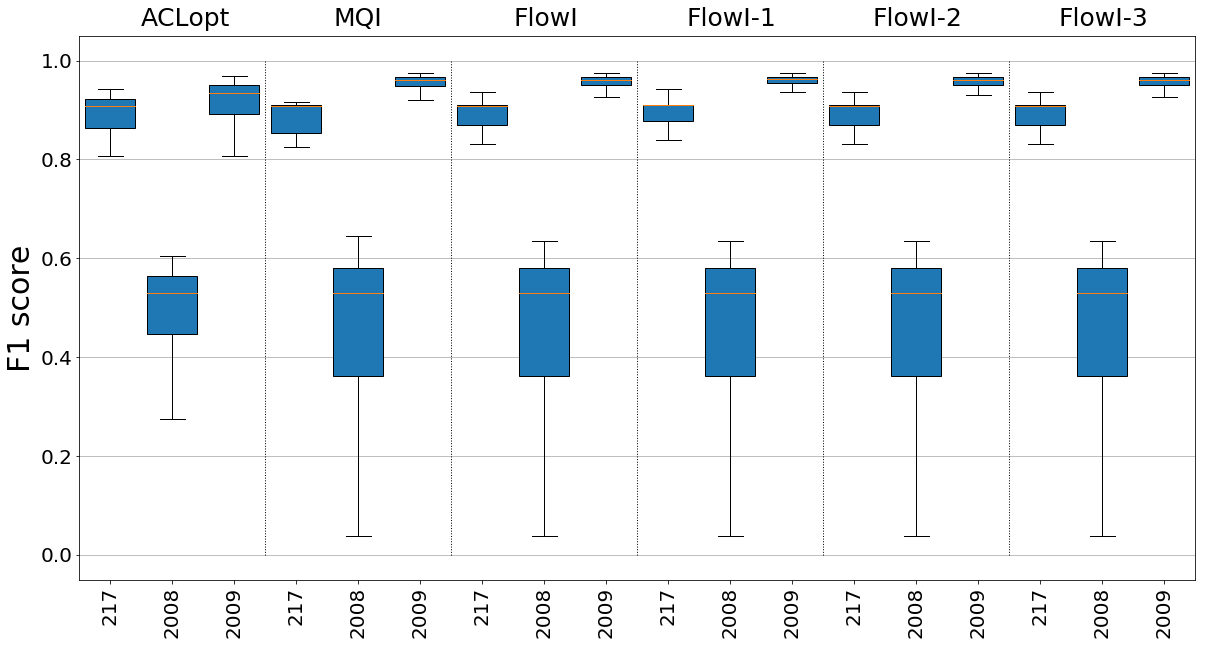

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_f1.png')

plt.show()

## Generate scatter plot for precision

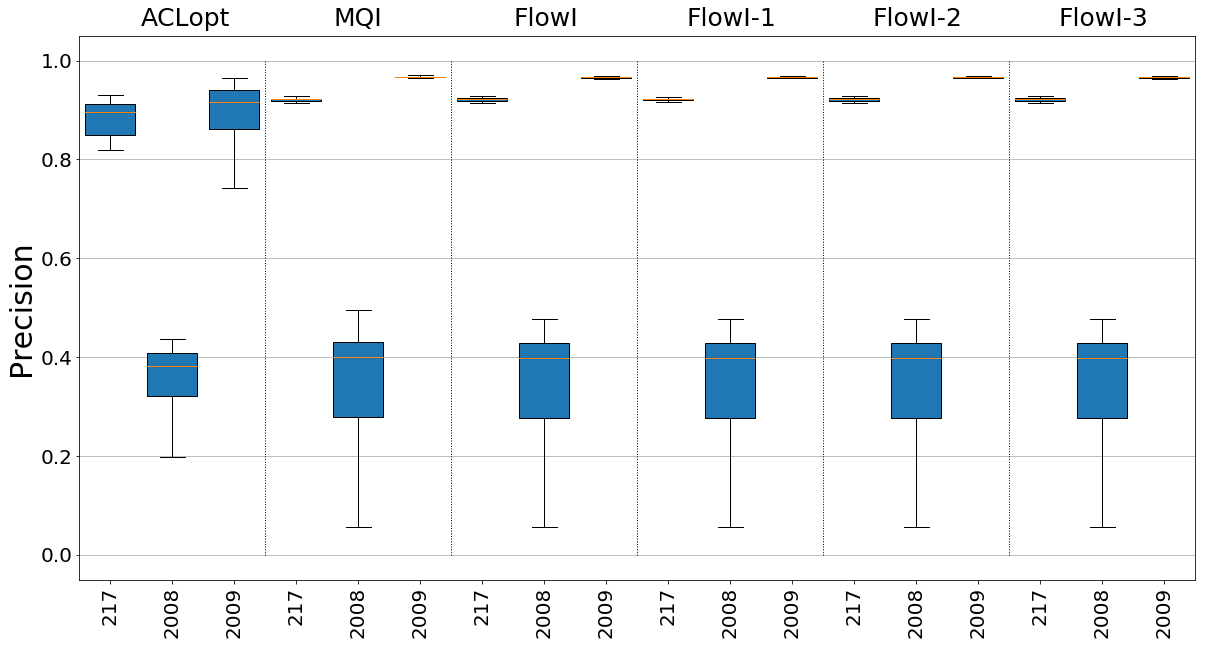

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_precision.png')

plt.show()

## Generate scatter plot for recall

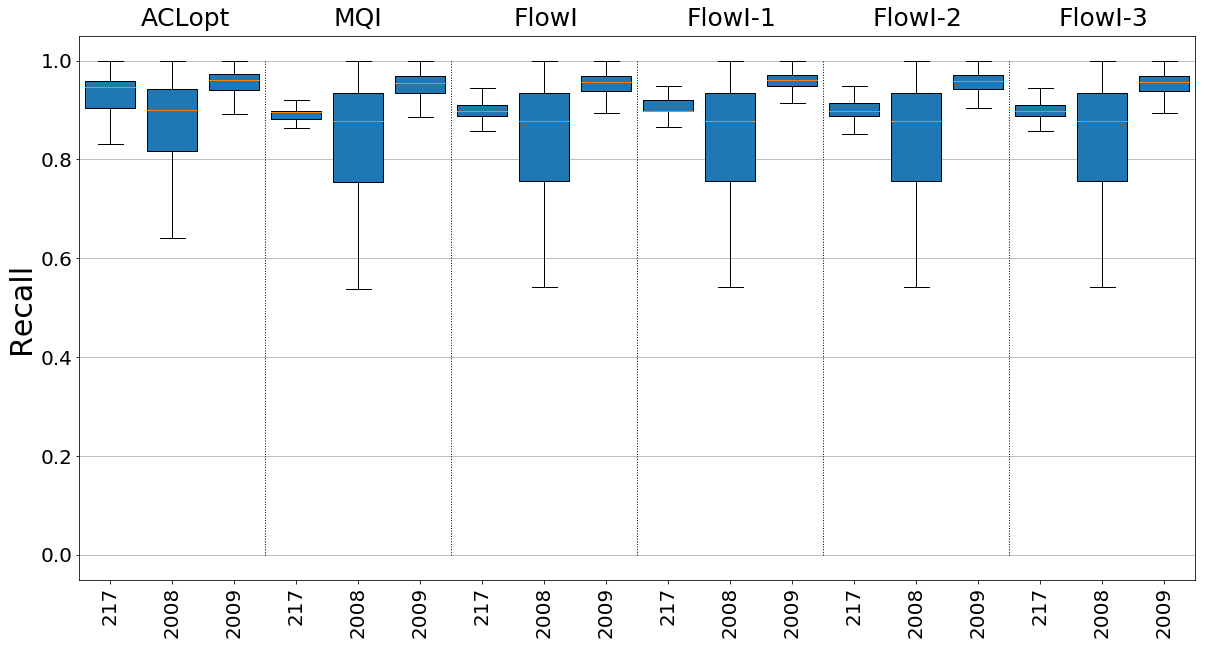

In [19]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Villanova62_recall.png')

plt.show()

In [20]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 217.0 Precision 0.8952115279325006 Recall 0.9465688107703815 F1 0.9084947993534331
Feature: 2008.0 Precision 0.3828358945054314 Recall 0.8993242835595776 F1 0.530300826269801
Feature: 2009.0 Precision 0.9166642109916016 Recall 0.9614223208233191 F1 0.9340288068282853
Results for MQI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8965033657442034 F1 0.908062357464424
Feature: 2008.0 Precision 0.4012108961608115 Recall 0.8786606334841629 F1 0.5298713612044961
Feature: 2009.0 Precision 0.966998639119139 Recall 0.9549516238368152 F1 0.9599615133927186
Results for FlowI
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8973448017950636 F1 0.9089099526066351
Feature: 2008.0 Precision 0.39894008455313623 Recall 0.87889592760181 F1 0.5289481672864287
Feature: 2009.0 Precision 0.9667094703049759 Recall 0.9575707154742097 F1 0.9611262544913889
Results for FlowI-1
Feature: 217.0 Precision 0.9217324498223375 Recall 0.8973448017950636 F1 0.9093751480411199
Featu